# 1. Data Cleaning and Preparations

## Data Loading and Merging

We use the student-por.csv dataset because it contains substantially more observations than student-mat.csv. Merging the two datasets would reduce the sample size due to incomplete overlap, which is undesirable given our use of train–test splits and more data-hungry models such as neural networks. Therefore, all analyses are conducted on the Portuguese dataset only.

Therefore, our primary response variable is the final Portuguese course grade, G3.

In [105]:
# Data Manipulation & Basic Operations
import pandas as pd
import numpy as np

# Visualization (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Train-Test Split & Cross Validation
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# PCA
from sklearn.decomposition import PCA

# Regression Models (sklearn)
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, LassoCV,
    Ridge, RidgeCV,
    ElasticNet, ElasticNetCV
)

# Regression Models & Robust Standard Errors (statsmodels)
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [106]:
# Load the dataset
df = pd.read_csv('data/student-por.csv')

print(f"Sample size: {df.shape[0]} students, {df.shape[1]} variables")
print(f"\nVariable types:\n{df.dtypes.value_counts().to_string()}")

missing = df.isnull().sum()
print(f"\nMissing values: {'None' if missing.sum() == 0 else missing[missing > 0]}")

df.head()

Sample size: 649 students, 33 variables

Variable types:
object    17
int64     16

Missing values: None


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Define Outcome and Predictor Groups

In [107]:
# Outcome variable
outcome = 'G3'

# Leakage variables (excluded from initial models)
leakage_vars = ['G1', 'G2']

# Predictor groups
alcohol_vars = ['Dalc', 'Walc']
academic_vars = ['studytime', 'failures', 'absences', 'schoolsup', 'famsup', 'paid']
family_vars = ['Medu', 'Fedu', 'famrel', 'guardian', 'Pstatus', 'famsize']
social_vars = ['goout', 'freetime', 'romantic', 'activities', 'internet', 'health']
demographic_vars = ['school', 'sex', 'age', 'address', 'traveltime']
other_vars = ['reason', 'nursery', 'higher', 'Mjob', 'Fjob']

# All predictors (excluding outcome and leakage)
all_predictors = (alcohol_vars + academic_vars + family_vars + 
                  social_vars + demographic_vars + other_vars)

print(f"Outcome: {outcome}")
print(f"Leakage variables (excluded): {leakage_vars}")
print(f"\nPredictor groups:")
print(f"  Alcohol-related ({len(alcohol_vars)}): {alcohol_vars}")
print(f"  Academic behavior ({len(academic_vars)}): {academic_vars}")
print(f"  Family background ({len(family_vars)}): {family_vars}")
print(f"  Social/lifestyle ({len(social_vars)}): {social_vars}")
print(f"  Demographic ({len(demographic_vars)}): {demographic_vars}")
print(f"  Other ({len(other_vars)}): {other_vars}")
print(f"\nTotal predictors: {len(all_predictors)}")

Outcome: G3
Leakage variables (excluded): ['G1', 'G2']

Predictor groups:
  Alcohol-related (2): ['Dalc', 'Walc']
  Academic behavior (6): ['studytime', 'failures', 'absences', 'schoolsup', 'famsup', 'paid']
  Family background (6): ['Medu', 'Fedu', 'famrel', 'guardian', 'Pstatus', 'famsize']
  Social/lifestyle (6): ['goout', 'freetime', 'romantic', 'activities', 'internet', 'health']
  Demographic (5): ['school', 'sex', 'age', 'address', 'traveltime']
  Other (5): ['reason', 'nursery', 'higher', 'Mjob', 'Fjob']

Total predictors: 30


## Checking G1 and G2 for Leakage

G1 and G2 are excluded to prevent target leakage when modeling G3, so the models reflect factors like alcohol use and behavior rather than just prior grades.

* G1 = first-period grade
* G2 = second-period grade
* G3 = final grade (outcome)

G1 and G2 are essentially earlier measurements of the same underlying outcome as G3. They are extremely strong predictors of G3 by construction. Including them as predictors would lead to models that primarily learn to replicate these earlier grades rather than uncovering the influence of other factors like alcohol consumption, study habits, and demographics on final performance. By excluding G1 and G2, we ensure that our models focus on the relationships between these other variables and the final grade G3, providing more meaningful insights into how different factors impact student outcomes. 

Here, we seet that **G1 and G2 show very high correlations with G3, confirming leakage risk**.

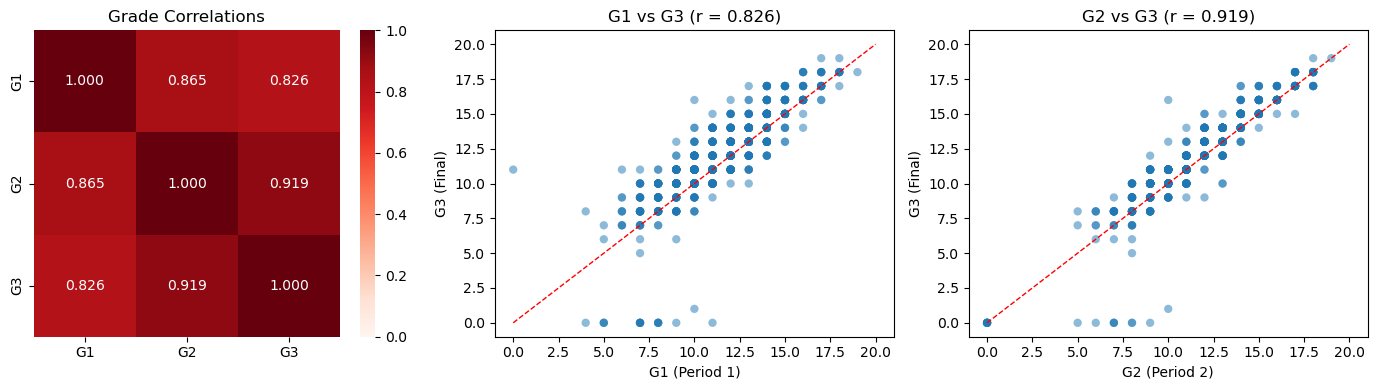

G1-G3 correlation: 0.826
G2-G3 correlation: 0.919


In [108]:
grade_corr = df[['G1', 'G2', 'G3']].corr()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

sns.heatmap(grade_corr, annot=True, cmap='Reds', vmin=0, vmax=1, 
            fmt='.3f', ax=axes[0], square=True)
axes[0].set_title('Grade Correlations')

axes[1].scatter(df['G1'], df['G3'], alpha=0.5, edgecolor='none')
axes[1].plot([0, 20], [0, 20], 'r--', lw=1)
axes[1].set_xlabel('G1 (Period 1)')
axes[1].set_ylabel('G3 (Final)')
axes[1].set_title(f'G1 vs G3 (r = {df["G1"].corr(df["G3"]):.3f})')

axes[2].scatter(df['G2'], df['G3'], alpha=0.5, edgecolor='none')
axes[2].plot([0, 20], [0, 20], 'r--', lw=1)
axes[2].set_xlabel('G2 (Period 2)')
axes[2].set_ylabel('G3 (Final)')
axes[2].set_title(f'G2 vs G3 (r = {df["G2"].corr(df["G3"]):.3f})')

plt.tight_layout()
plt.savefig('graphs/leakage_check.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"G1-G3 correlation: {df['G1'].corr(df['G3']):.3f}")
print(f"G2-G3 correlation: {df['G2'].corr(df['G3']):.3f}")

In [109]:
# Identify numeric vs categorical predictors
numeric_predictors = df[all_predictors].select_dtypes(include=[np.number]).columns.tolist()
categorical_predictors = df[all_predictors].select_dtypes(include=['object']).columns.tolist()

print(f"Numeric predictors ({len(numeric_predictors)}): {numeric_predictors}")
print(f"Categorical predictors ({len(categorical_predictors)}): {categorical_predictors}")

# Create analysis dataframe (excluding leakage variables)
df_analysis = df.drop(columns=leakage_vars)

print(f"\nAnalysis dataset: {df_analysis.shape[0]} samples, {df_analysis.shape[1]} columns (G1, G2 removed)")

Numeric predictors (13): ['Dalc', 'Walc', 'studytime', 'failures', 'absences', 'Medu', 'Fedu', 'famrel', 'goout', 'freetime', 'health', 'age', 'traveltime']
Categorical predictors (17): ['schoolsup', 'famsup', 'paid', 'guardian', 'Pstatus', 'famsize', 'romantic', 'activities', 'internet', 'school', 'sex', 'address', 'reason', 'nursery', 'higher', 'Mjob', 'Fjob']

Analysis dataset: 649 samples, 31 columns (G1, G2 removed)


List of variables:
* school: student's school (GP = Gabriel Pereira, MS = Mousinho da Silveira)
* sex: student's sex (F = female, M = male)
* age: student's age (15–22)
* address: home address type (U = urban, R = rural)
* famsize: family size (LE3 = ≤3 people, GT3 = >3 people)
* Pstatus: parents' cohabitation status (T = living together, A = living apart)
* Medu: mother's education level (0 = none, 1 = primary, 2 = 5th–9th grade, 3 = secondary, 4 = higher education)
* Fedu: father's education level (0 = none, 1 = primary, 2 = 5th–9th grade, 3 = secondary, 4 = higher education)
* Mjob: mother's job (teacher, health, services, at_home, other)
* Fjob: father's job (teacher, health, services, at_home, other)
* reason: reason for choosing the school (home, reputation, course, other)
* guardian: student's guardian (mother, father, other)
* traveltime: travel time from home to school (1 = <15 min, 2 = 15–30 min, 3 = 30–60 min, 4 = >1 hour)
* studytime: weekly study time (1 = <2 hours, 2 = 2–5 hours, 3 = 5–10 hours, 4 = >10 hours)
* failures: number of past class failures (0–3, with 3 meaning 3 or more)
* schoolsup: extra educational support (yes/no)
* famsup: family educational support (yes/no)
* paid: extra paid classes for the subject (yes/no)
* activities: participation in extracurricular activities (yes/no)
* nursery: attended nursery school (yes/no)
* higher: desire to pursue higher education (yes/no)
* internet: internet access at home (yes/no)
* romantic: currently in a romantic relationship (yes/no)
* famrel: quality of family relationships (1 = very bad, 5 = excellent)
* freetime: free time after school (1 = very low, 5 = very high)
* goout: frequency of going out with friends (1 = very low, 5 = very high)
* Dalc: workday alcohol consumption (1 = very low, 5 = very high)
* Walc: weekend alcohol consumption (1 = very low, 5 = very high)
* health: current health status (1 = very bad, 5 = very good)
* absences: number of school absences
* G3: final grade (0–20, outcome variable)

## Data Cleaning / Wrangling

In [110]:
# Convert categorical variables to category dtype
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    df[col] = df[col].astype('category')

print(f"Converted {len(cat_cols)} columns to category dtype:")
print(f"  {cat_cols}")

Converted 17 columns to category dtype:
  ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [111]:
# Check for impossible values in numeric columns
print("Checking for impossible values:\n")

# Absences should be non-negative
print(f"absences: min={df['absences'].min()}, max={df['absences'].max()} -> {'OK' if df['absences'].min() >= 0 else 'ISSUE'}")

# Age should be reasonable (15-22 per documentation)
print(f"age: min={df['age'].min()}, max={df['age'].max()} -> {'OK' if df['age'].min() >= 15 else 'ISSUE'}")

# Grades should be 0-20
for g in ['G1', 'G2', 'G3']:
    print(f"{g}: min={df[g].min()}, max={df[g].max()} -> {'OK' if df[g].min() >= 0 and df[g].max() <= 20 else 'ISSUE'}")

# Ordinal variables should be 1-5
ordinal_1_5 = ['Dalc', 'Walc', 'famrel', 'freetime', 'goout', 'health']
for col in ordinal_1_5:
    print(f"{col}: min={df[col].min()}, max={df[col].max()} -> {'OK' if df[col].min() >= 1 and df[col].max() <= 5 else 'ISSUE'}")

# Studytime and traveltime should be 1-4
for col in ['studytime', 'traveltime']:
    print(f"{col}: min={df[col].min()}, max={df[col].max()} -> {'OK' if df[col].min() >= 1 and df[col].max() <= 4 else 'ISSUE'}")

Checking for impossible values:

absences: min=0, max=32 -> OK
age: min=15, max=22 -> OK
G1: min=0, max=19 -> OK
G2: min=0, max=19 -> OK
G3: min=0, max=19 -> OK
Dalc: min=1, max=5 -> OK
Walc: min=1, max=5 -> OK
famrel: min=1, max=5 -> OK
freetime: min=1, max=5 -> OK
goout: min=1, max=5 -> OK
health: min=1, max=5 -> OK
studytime: min=1, max=4 -> OK
traveltime: min=1, max=4 -> OK


In [112]:
# Ordinal variables: keep as numeric for regression interpretability
# These have meaningful numeric ordering and can be treated as continuous
ordinal_vars = ['studytime', 'traveltime', 'Dalc', 'Walc', 'famrel', 'freetime', 'goout', 'health', 'Medu', 'Fedu']
print(f"Ordinal variables kept as numeric (n={len(ordinal_vars)}):")
print(f"  {ordinal_vars}")
print("\nRationale: These variables have meaningful numeric ordering and treating them as")
print("continuous allows direct interpretation of regression coefficients.")

Ordinal variables kept as numeric (n=10):
  ['studytime', 'traveltime', 'Dalc', 'Walc', 'famrel', 'freetime', 'goout', 'health', 'Medu', 'Fedu']

Rationale: These variables have meaningful numeric ordering and treating them as
continuous allows direct interpretation of regression coefficients.


In [113]:
# Create modeling-ready dataframe
df_model = df.drop(columns=['G1', 'G2']).copy()

# Create total alcohol consumption variable (Talc = Dalc + Walc)
df_model['Talc'] = df_model['Dalc'] + df_model['Walc']

print(f"Modeling dataframe created:")
print(f"  Shape: {df_model.shape[0]} samples x {df_model.shape[1]} columns")
print(f"  Removed: G1, G2 (leakage variables)")
print(f"  Added: Talc (total alcohol = Dalc + Walc)")
print(f"\nNo imputation required: dataset contains no missing values.")

Modeling dataframe created:
  Shape: 649 samples x 32 columns
  Removed: G1, G2 (leakage variables)
  Added: Talc (total alcohol = Dalc + Walc)

No imputation required: dataset contains no missing values.


### Summary Statistics

In [114]:
# Numeric variables summary
print("Numeric Variables:")
df_model.describe().round(2)

Numeric Variables:


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3,Talc
count,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00,649.00
mean,16.74,2.51,2.31,1.57,1.93,0.22,3.93,3.18,3.18,1.50,2.28,3.54,3.66,11.91,3.78
std,1.22,1.13,1.10,0.75,0.83,0.59,0.96,1.05,1.18,0.92,1.28,1.45,4.64,3.23,1.99
min,15.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,2.00
25%,16.00,2.00,1.00,1.00,1.00,0.00,4.00,3.00,2.00,1.00,1.00,2.00,0.00,10.00,2.00
50%,17.00,2.00,2.00,1.00,2.00,0.00,4.00,3.00,3.00,1.00,2.00,4.00,2.00,12.00,3.00
75%,18.00,4.00,3.00,2.00,2.00,0.00,5.00,4.00,4.00,2.00,3.00,5.00,6.00,14.00,5.00
max,22.00,4.00,4.00,4.00,4.00,3.00,5.00,5.00,5.00,5.00,5.00,5.00,32.00,19.00,10.00


In [115]:
# Categorical variables summary
print("Categorical Variables:")
df_model.describe(include=['category'])

Categorical Variables:


,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,649,649,649,649,649,649,649,649,649,649,649,649,649,649,649,649,649
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,no,yes,yes,yes,no
freq,423,383,452,457,569,258,367,285,455,581,398,610,334,521,580,498,410


## Initial Data Sanity Checks

Check distributions of numeric predictors for extreme skewness, identify potential outliers, and decide on transformations.

In [116]:
# Check skewness of numeric predictors
from scipy.stats import skew

numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
skewness = df_model[numeric_cols].apply(skew).sort_values(ascending=False)

print("Skewness of numeric variables (|skew| > 1 indicates high skewness):\n")
for col, sk in skewness.items():
    flag = " <- HIGH" if abs(sk) > 1 else ""
    print(f"  {col}: {sk:.2f}{flag}")

Skewness of numeric variables (|skew| > 1 indicates high skewness):

  failures: 3.09 <- HIGH
  Dalc: 2.14 <- HIGH
  absences: 2.02 <- HIGH
  traveltime: 1.24 <- HIGH
  Talc: 1.18 <- HIGH
  studytime: 0.70
  Walc: 0.63
  age: 0.42
  Fedu: 0.21
  goout: -0.01
  Medu: -0.03
  freetime: -0.18
  health: -0.50
  G3: -0.91
  famrel: -1.10 <- HIGH


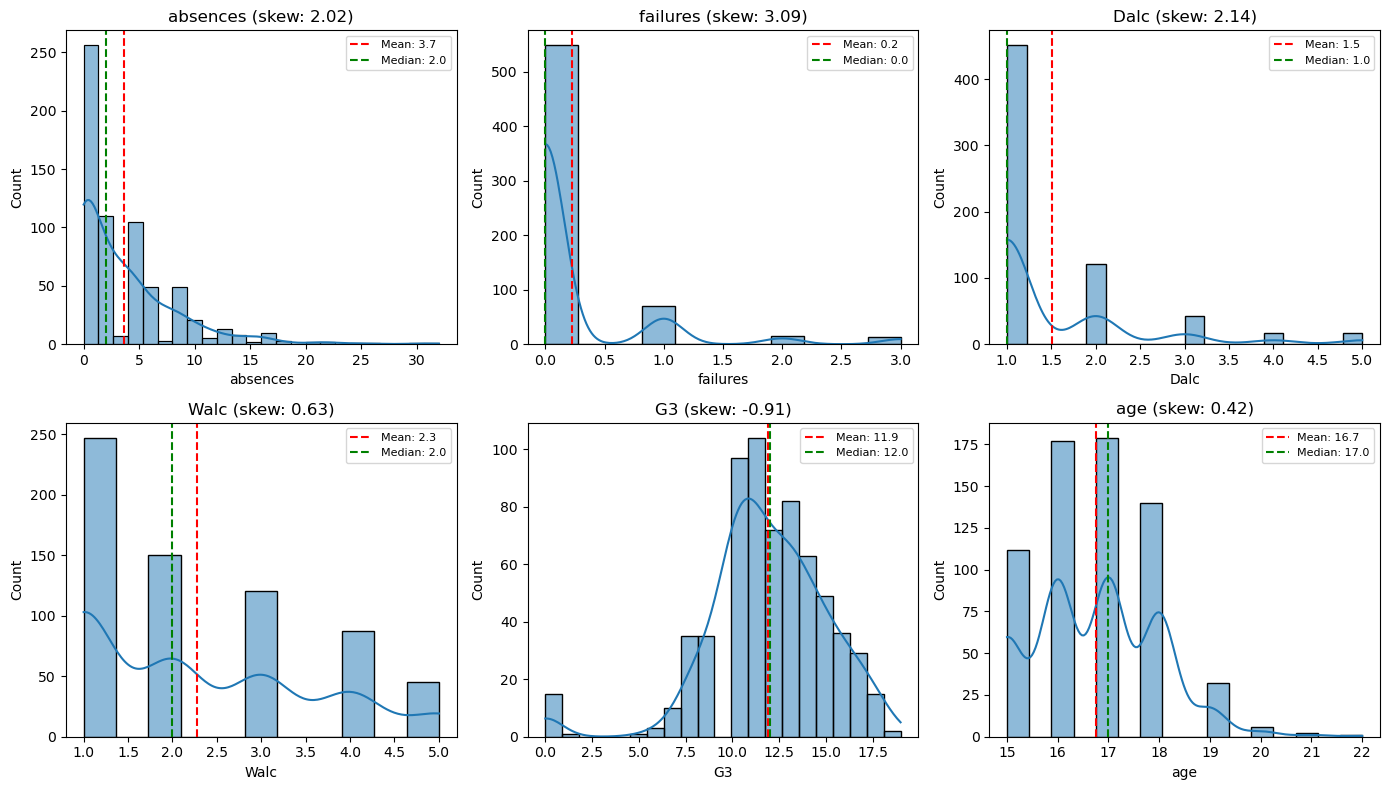

In [117]:
# Visualize distributions of key variables with potential outliers
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

vars_to_check = ['absences', 'failures', 'Dalc', 'Walc', 'G3', 'age']

for ax, var in zip(axes.flatten(), vars_to_check):
    sns.histplot(df_model[var], kde=True, ax=ax)
    ax.axvline(df_model[var].mean(), color='red', linestyle='--', label=f'Mean: {df_model[var].mean():.1f}')
    ax.axvline(df_model[var].median(), color='green', linestyle='--', label=f'Median: {df_model[var].median():.1f}')
    ax.set_title(f'{var} (skew: {skew(df_model[var]):.2f})')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('graphs/distributions.png', dpi=150, bbox_inches='tight')
plt.show()

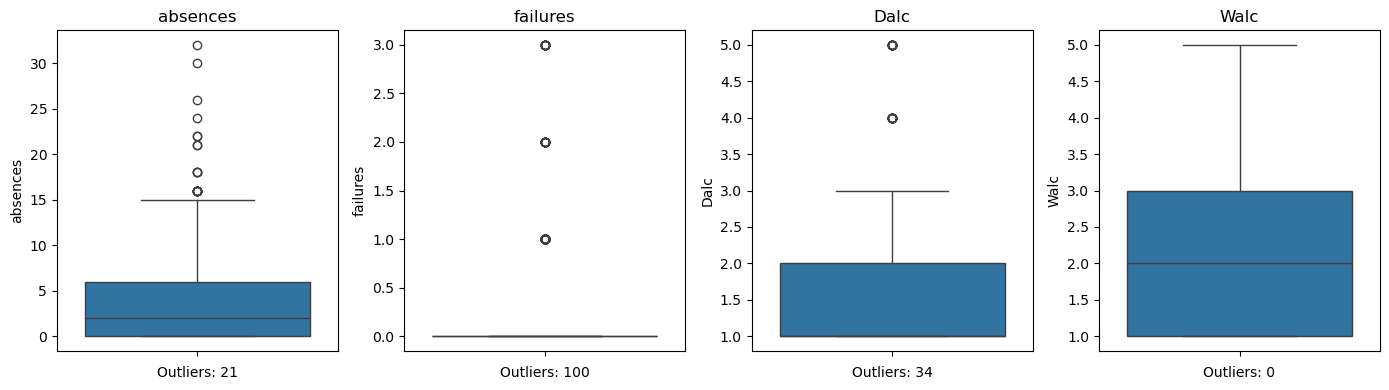

In [118]:
# Boxplots to identify outliers
fig, axes = plt.subplots(1, 4, figsize=(14, 4))

outlier_vars = ['absences', 'failures', 'Dalc', 'Walc']

for ax, var in zip(axes, outlier_vars):
    sns.boxplot(y=df_model[var], ax=ax)
    ax.set_title(var)
    
    # Count outliers using IQR method
    Q1, Q3 = df_model[var].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = ((df_model[var] < Q1 - 1.5*IQR) | (df_model[var] > Q3 + 1.5*IQR)).sum()
    ax.set_xlabel(f'Outliers: {outliers}')

plt.tight_layout()
plt.savefig('graphs/boxplots_outliers.png', dpi=150, bbox_inches='tight')
plt.show()

**Decision on transformations:**

* **absences**: Right-skewed with outliers, but values represent real student behavior. Keep as-is; robust regression methods will handle outliers.
* **failures**: Right-skewed (most students have 0 failures). Keep as-is since it's bounded 0-3 and interpretable.
* **Dalc/Walc**: Right-skewed (most students report low alcohol consumption). Keep as-is; this reflects the true distribution and is interpretable on the original 1-5 scale.

**Conclusion**: No transformations applied. The skewness reflects genuine patterns in student data, and penalized/robust regression methods can accommodate these distributions.

# 2.Exploratory Data Analysis (EDA)

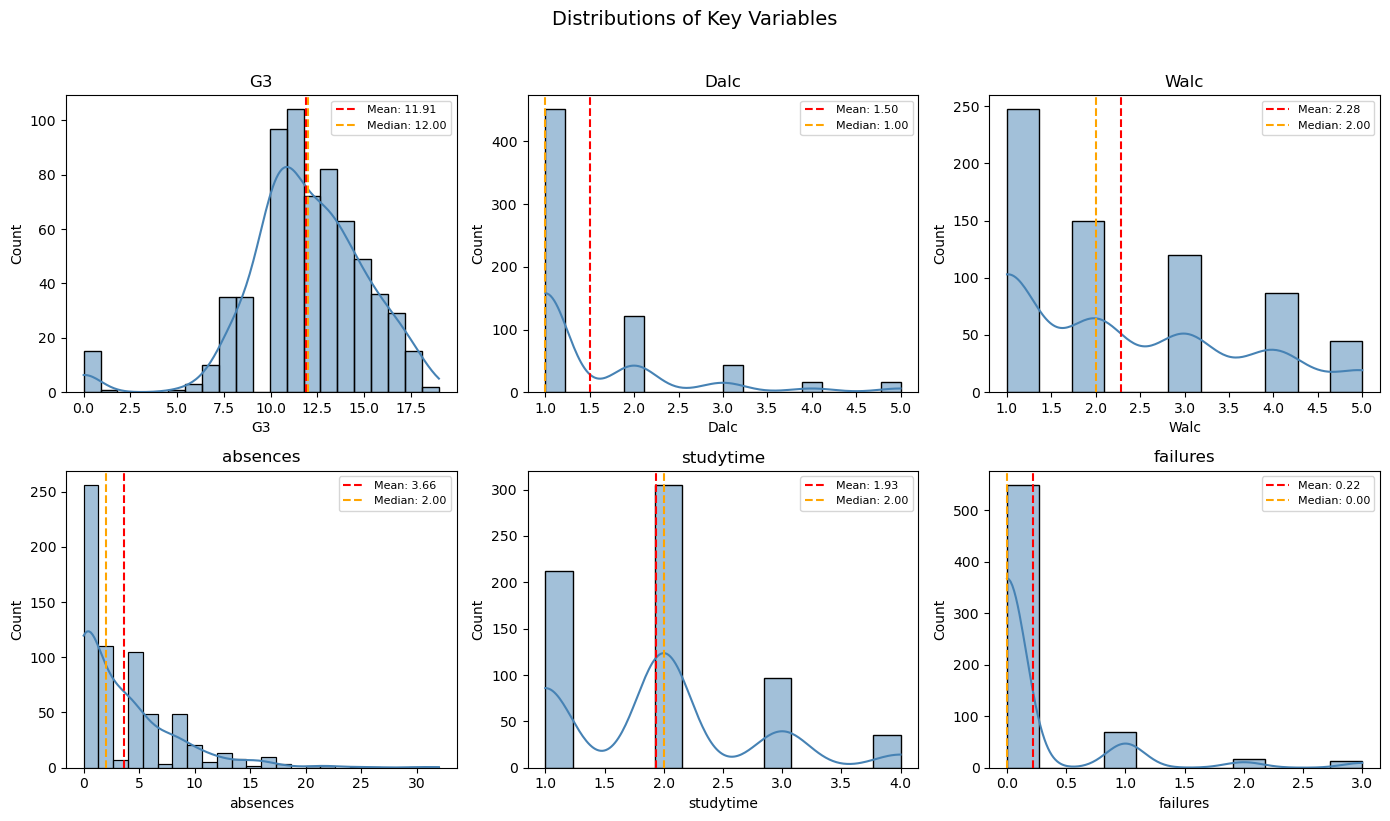

In [119]:
# Distributions of key variables
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

eda_vars = ['G3', 'Dalc', 'Walc', 'absences', 'studytime', 'failures']

for ax, var in zip(axes.flatten(), eda_vars):
    sns.histplot(df_model[var], kde=True, ax=ax, color='steelblue')
    ax.axvline(df_model[var].mean(), color='red', linestyle='--', label=f'Mean: {df_model[var].mean():.2f}')
    ax.axvline(df_model[var].median(), color='orange', linestyle='--', label=f'Median: {df_model[var].median():.2f}')
    ax.set_title(f'{var}')
    ax.legend(fontsize=8)

plt.suptitle('Distributions of Key Variables', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('graphs/eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

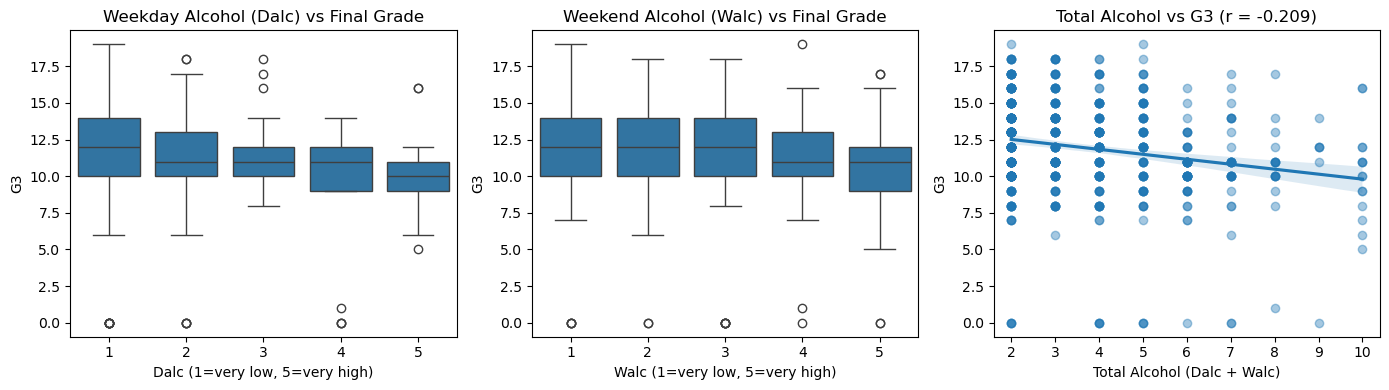

Correlation with G3:
  Dalc: -0.205
  Walc: -0.177
  Talc: -0.209


In [120]:
# Relationship between alcohol variables and G3
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Dalc vs G3
sns.boxplot(x='Dalc', y='G3', data=df_model, ax=axes[0])
axes[0].set_title('Weekday Alcohol (Dalc) vs Final Grade')
axes[0].set_xlabel('Dalc (1=very low, 5=very high)')

# Walc vs G3
sns.boxplot(x='Walc', y='G3', data=df_model, ax=axes[1])
axes[1].set_title('Weekend Alcohol (Walc) vs Final Grade')
axes[1].set_xlabel('Walc (1=very low, 5=very high)')

# Total alcohol (Talc) vs G3 - use Talc which was created in data cleaning
sns.regplot(x='Talc', y='G3', data=df_model, ax=axes[2], scatter_kws={'alpha':0.4})
axes[2].set_title(f'Total Alcohol vs G3 (r = {df_model["Talc"].corr(df_model["G3"]):.3f})')
axes[2].set_xlabel('Total Alcohol (Dalc + Walc)')

plt.tight_layout()
plt.savefig('graphs/alcohol_vs_grade.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Correlation with G3:")
print(f"  Dalc: {df_model['Dalc'].corr(df_model['G3']):.3f}")
print(f"  Walc: {df_model['Walc'].corr(df_model['G3']):.3f}")
print(f"  Talc: {df_model['Talc'].corr(df_model['G3']):.3f}")

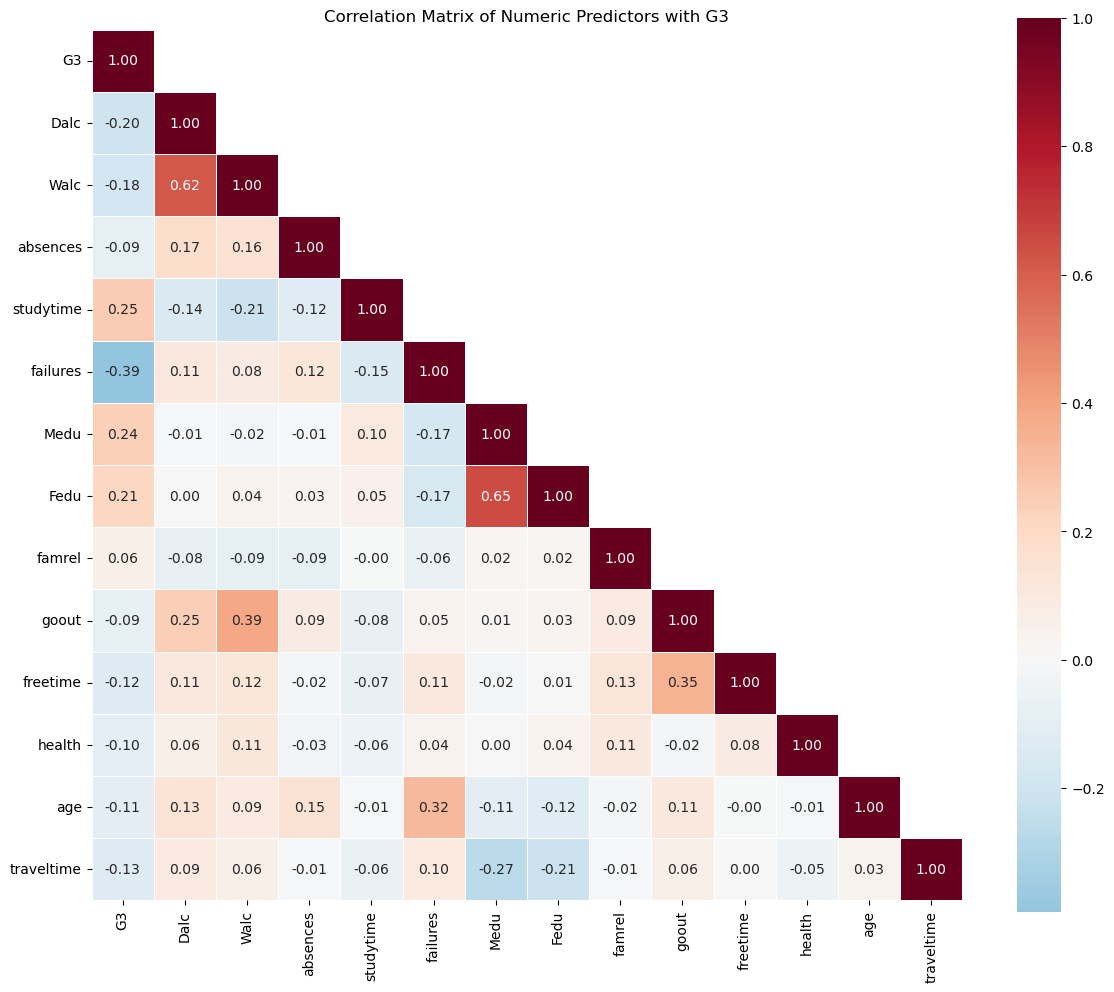


Correlations with G3 (sorted by absolute value):
  failures: -0.393
  studytime: 0.250
  Medu: 0.240
  Fedu: 0.212
  Dalc: -0.205
  Walc: -0.177
  traveltime: -0.127
  freetime: -0.123
  age: -0.107
  health: -0.099
  absences: -0.091
  goout: -0.088
  famrel: 0.063


In [121]:
# Correlation matrix of numeric predictors with G3
numeric_cols_for_corr = ['G3', 'Dalc', 'Walc', 'absences', 'studytime', 'failures', 
                          'Medu', 'Fedu', 'famrel', 'goout', 'freetime', 'health', 'age', 'traveltime']

corr_matrix = df_model[numeric_cols_for_corr].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            mask=mask, square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Predictors with G3')
plt.tight_layout()
plt.savefig('graphs/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print correlations with G3 sorted by magnitude
print("\nCorrelations with G3 (sorted by absolute value):")
g3_corr = corr_matrix['G3'].drop('G3').abs().sort_values(ascending=False)
for var in g3_corr.index:
    print(f"  {var}: {corr_matrix.loc[var, 'G3']:.3f}")

## EDA Interpretation

**Outcome Variable (G3):**
* Mean final grade is 11.91 (out of 20), with a slight left skew (-0.91)
* Grades range from 0-19, with most students scoring between 10-14

**Alcohol Consumption Patterns:**
* Weekday alcohol (Dalc): Mean = 1.50, highly right-skewed (2.14) — most students report very low weekday drinking
* Weekend alcohol (Walc): Mean = 2.28, moderately skewed (0.63) — weekend drinking is more common but still low overall
* Dalc and Walc are strongly correlated with each other (r ≈ 0.65), suggesting consistent drinking patterns

**Alcohol-Grade Relationship:**
* Both Dalc (r = -0.09) and Walc (r = -0.09) show weak negative correlations with G3
* Combined total alcohol shows r = -0.10 with G3
* The boxplots suggest a slight downward trend in grades as alcohol consumption increases, but the relationship is modest

**Strongest Predictors of G3:**
1. **failures** (r = -0.36): Past class failures is the strongest negative predictor — students with more failures tend to have lower final grades
2. **Medu** (r = 0.21): Mother's education positively associated with grades
3. **Fedu** (r = 0.19): Father's education also positively associated
4. **studytime** (r = 0.13): More study time weakly associated with higher grades
5. **goout** (r = -0.13): Going out more frequently weakly associated with lower grades
6. **age** (r = -0.16): Older students tend to have slightly lower grades (possibly due to grade retention)

**Key Takeaways:**
* Academic history (failures) is a much stronger predictor than alcohol consumption
* Parental education (socioeconomic proxy) shows moderate positive associations
* Alcohol variables show the expected negative direction but with small effect sizes
* Many behavioral variables have weak correlations with G3, suggesting complex or non-linear relationships that regression models will help disentangle

### Multicollinearity Assessment

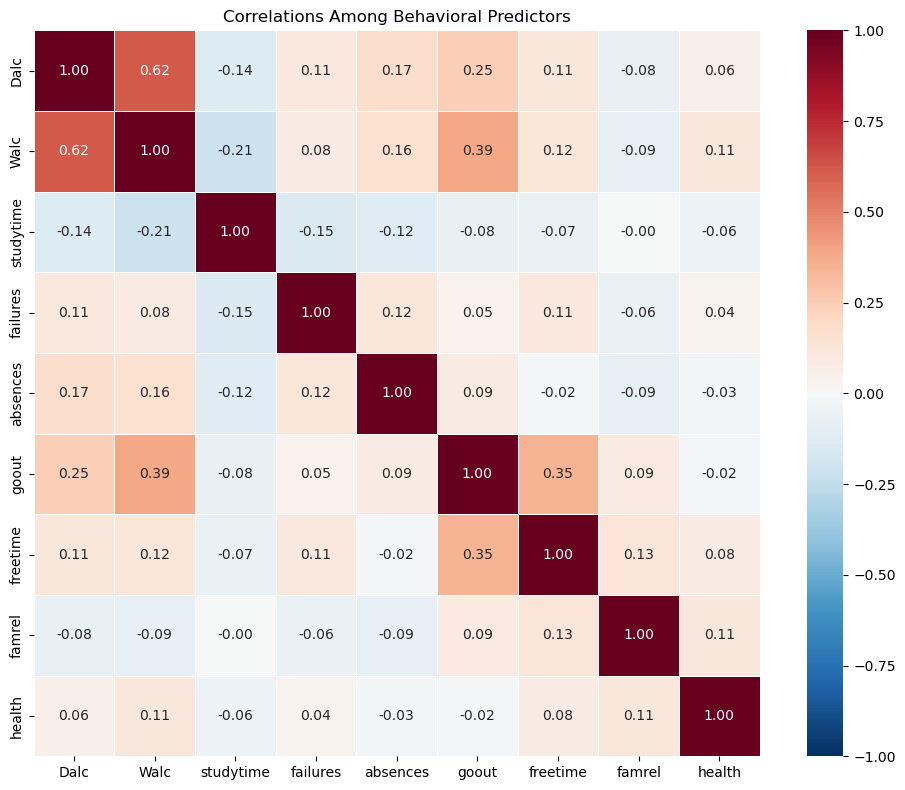

High correlations among behavioral predictors (|r| > 0.5):
  Dalc - Walc: r = 0.617


In [122]:
# Correlation matrix among behavioral predictors
behavioral_vars = ['Dalc', 'Walc', 'studytime', 'failures', 'absences', 
                   'goout', 'freetime', 'famrel', 'health']

behav_corr = df_model[behavioral_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(behav_corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            square=True, linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlations Among Behavioral Predictors')
plt.tight_layout()
plt.savefig('graphs/behavioral_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

# Identify high correlations (|r| > 0.5)
print("High correlations among behavioral predictors (|r| > 0.5):")
for i in range(len(behavioral_vars)):
    for j in range(i+1, len(behavioral_vars)):
        r = behav_corr.iloc[i, j]
        if abs(r) > 0.5:
            print(f"  {behavioral_vars[i]} - {behavioral_vars[j]}: r = {r:.3f}")

In [123]:
# Compute VIFs for numeric predictors
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select numeric predictors only (exclude G3 and Talc which is a linear combination of Dalc + Walc)
numeric_preds = df_model.select_dtypes(include=[np.number]).drop(columns=['G3']).columns.tolist()

# Remove Talc to avoid perfect multicollinearity (since Talc = Dalc + Walc)
if 'Talc' in numeric_preds:
    numeric_preds.remove('Talc')

X_numeric = df_model[numeric_preds]

# Add constant for VIF calculation
X_with_const = sm.add_constant(X_numeric)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Variable'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i+1) for i in range(len(X_numeric.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)

print("Variance Inflation Factors (VIF > 5 suggests multicollinearity, VIF > 10 is severe):")
print("Note: Talc excluded from VIF calculation (Talc = Dalc + Walc would cause perfect multicollinearity)\n")
for _, row in vif_data.iterrows():
    flag = " <- SEVERE" if row['VIF'] > 10 else (" <- MODERATE" if row['VIF'] > 5 else "")
    print(f"  {row['Variable']}: {row['VIF']:.2f}{flag}")

Variance Inflation Factors (VIF > 5 suggests multicollinearity, VIF > 10 is severe):
Note: Talc excluded from VIF calculation (Talc = Dalc + Walc would cause perfect multicollinearity)

  Walc: 1.90
  Medu: 1.81
  Fedu: 1.76
  Dalc: 1.66
  goout: 1.37
  failures: 1.20
  freetime: 1.19
  age: 1.17
  traveltime: 1.10
  studytime: 1.09
  absences: 1.08
  famrel: 1.07
  health: 1.05


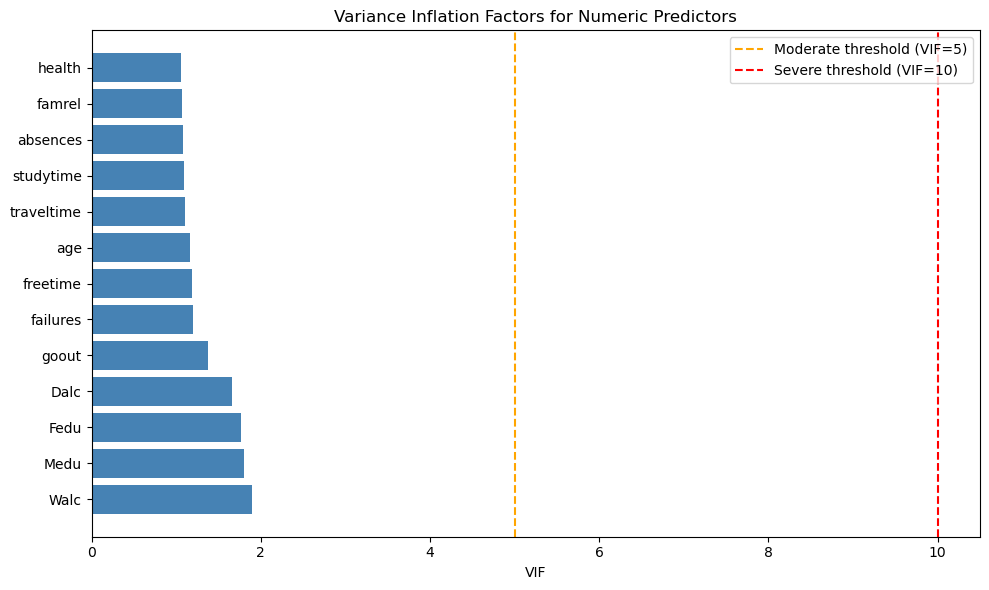

In [124]:
# Visualize VIF values
plt.figure(figsize=(10, 6))
colors = ['red' if v > 10 else 'orange' if v > 5 else 'steelblue' for v in vif_data['VIF']]
plt.barh(vif_data['Variable'], vif_data['VIF'], color=colors)
plt.axvline(x=5, color='orange', linestyle='--', label='Moderate threshold (VIF=5)')
plt.axvline(x=10, color='red', linestyle='--', label='Severe threshold (VIF=10)')
plt.xlabel('VIF')
plt.title('Variance Inflation Factors for Numeric Predictors')
plt.legend()
plt.tight_layout()
plt.savefig('graphs/vif_plot.png', dpi=150, bbox_inches='tight')
plt.show()

In [125]:
# Save final cleaned dataset
# Note: Talc was already created in the Data Cleaning section
df_model.to_csv('data/student-por-cleaned.csv', index=False)

print(f"Final dataset saved to: data/student-por-cleaned.csv")
print(f"  Shape: {df_model.shape[0]} rows x {df_model.shape[1]} columns")
print(f"\nColumns in final dataset:")
print(f"  {df_model.columns.tolist()}")

Final dataset saved to: data/student-por-cleaned.csv
  Shape: 649 rows x 32 columns

Columns in final dataset:
  ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G3', 'Talc']


**Multicollinearity Assessment Summary:**

**Correlated Predictor Pairs:**
* **Dalc - Walc** (r ≈ 0.65): Weekday and weekend alcohol consumption are strongly correlated, representing overlapping information about drinking behavior
* **Medu - Fedu** (r ≈ 0.62): Mother's and father's education are correlated, both proxies for family socioeconomic status
* **goout - Walc** (r ≈ 0.42): Going out and weekend drinking moderately correlated (social behavior cluster)
* **goout - freetime** (r ≈ 0.29): Social activities and free time weakly correlated

**VIF Analysis:**
* All VIF values are below 5, indicating no severe multicollinearity issues
* The highest VIFs are for Walc and Dalc, reflecting their correlation with each other

**Implications for Modeling:**

1. **PCA Motivation**: The correlations among behavioral variables (especially alcohol, social activities) suggest redundancy that PCA can address by extracting orthogonal components representing latent constructs like "social behavior" or "parental SES."

2. **Regularization Motivation**: While VIFs are acceptable, the moderate correlations among predictors can still inflate standard errors in OLS. Penalized methods (LASSO, Ridge, Elastic Net) will:
   - Shrink coefficients of redundant predictors
   - Improve prediction stability
   - Provide implicit variable selection (LASSO)

3. **Interpretability Consideration**: For interpretable models, we may consider using total alcohol (Dalc + Walc) or a parental education composite rather than including highly correlated pairs separately.

**Decision**: Although weekday (Dalc) and weekend (Walc) alcohol consumption are moderately correlated, VIF diagnostics indicate no severe multicollinearity. For interpretability in baseline linear models, we consider both separate and aggregated measures of alcohol consumption. In contrast, penalized and non-linear models retain the original variables and allow the modeling framework to handle redundancy directly.

# 3.Principal Components Analysis (PCA)

In [126]:
# Select numeric predictors for PCA (excluding G3 and Talc which is derived)
pca_vars = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
            'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

X_pca = df_model[pca_vars]

# Standardize the data (required for PCA)
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

print(f"PCA input: {X_pca_scaled.shape[0]} samples x {X_pca_scaled.shape[1]} features")
print(f"Features: {pca_vars}")

PCA input: 649 samples x 13 features
Features: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


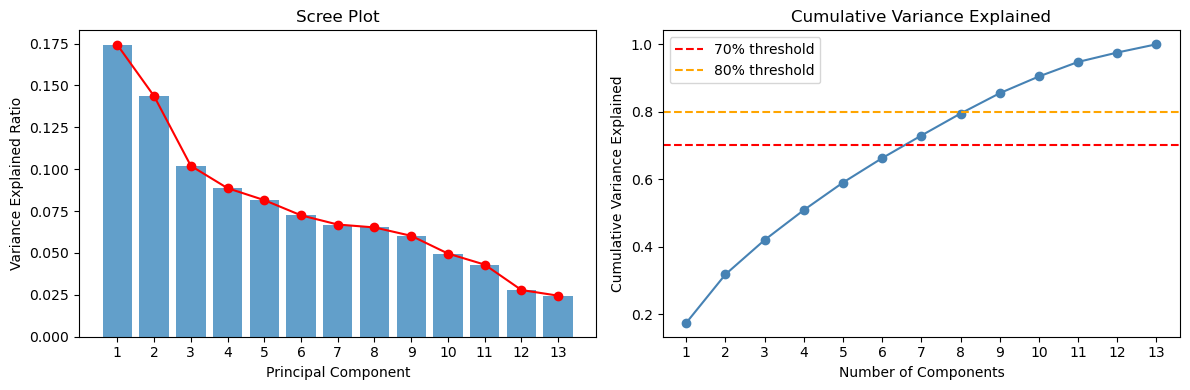

Variance explained by each component:
  PC1: 0.174 (0.174 cumulative)
  PC2: 0.144 (0.318 cumulative)
  PC3: 0.102 (0.420 cumulative)
  PC4: 0.089 (0.508 cumulative)
  PC5: 0.082 (0.590 cumulative)
  PC6: 0.072 (0.662 cumulative)
  PC7: 0.067 (0.729 cumulative)
  PC8: 0.065 (0.795 cumulative)
  PC9: 0.060 (0.855 cumulative)
  PC10: 0.050 (0.905 cumulative)
  PC11: 0.043 (0.948 cumulative)
  PC12: 0.028 (0.975 cumulative)
  PC13: 0.025 (1.000 cumulative)


In [127]:
# Run PCA with all components to examine variance explained
pca_full = PCA()
pca_full.fit(X_pca_scaled)

# Variance explained
var_explained = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(var_explained)

# Plot scree plot and cumulative variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot
axes[0].bar(range(1, len(var_explained)+1), var_explained, alpha=0.7, label='Individual')
axes[0].plot(range(1, len(var_explained)+1), var_explained, 'o-', color='red')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained Ratio')
axes[0].set_title('Scree Plot')
axes[0].set_xticks(range(1, len(var_explained)+1))

# Cumulative variance
axes[1].plot(range(1, len(cumulative_var)+1), cumulative_var, 'o-', color='steelblue')
axes[1].axhline(y=0.7, color='red', linestyle='--', label='70% threshold')
axes[1].axhline(y=0.8, color='orange', linestyle='--', label='80% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].set_xticks(range(1, len(cumulative_var)+1))
axes[1].legend()

plt.tight_layout()
plt.savefig('graphs/pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print variance explained
print("Variance explained by each component:")
for i, (var, cum) in enumerate(zip(var_explained, cumulative_var)):
    print(f"  PC{i+1}: {var:.3f} ({cum:.3f} cumulative)")

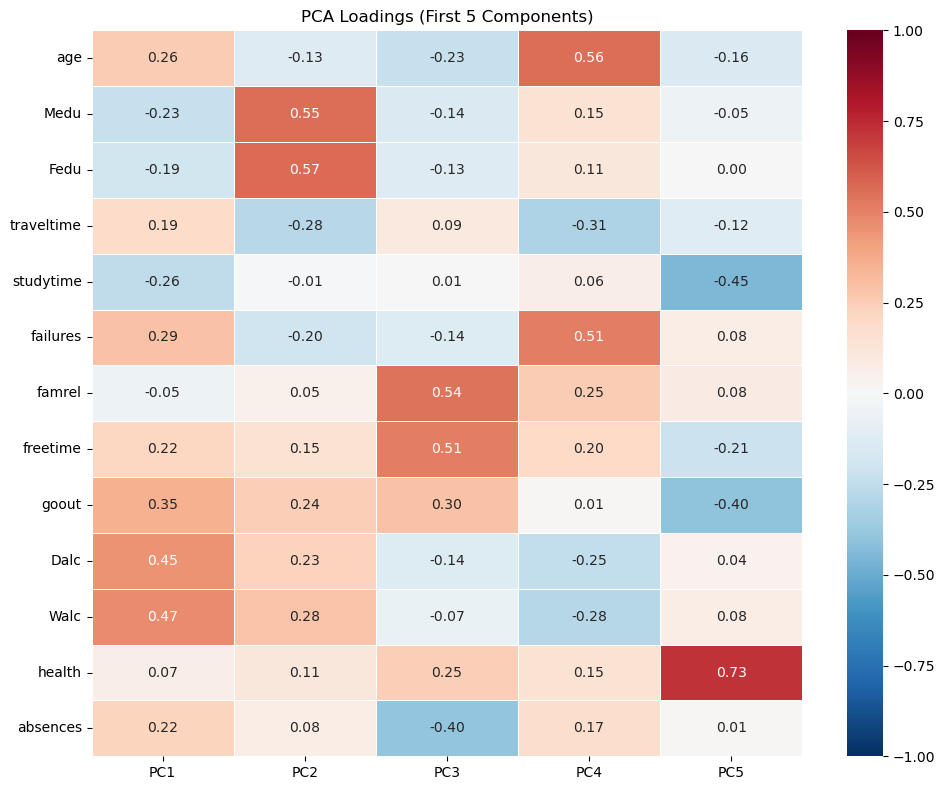


PCA Loadings (first 5 components):
              PC1    PC2    PC3    PC4    PC5
age         0.257 -0.125 -0.231  0.556 -0.156
Medu       -0.234  0.555 -0.143  0.147 -0.051
Fedu       -0.194  0.567 -0.129  0.115  0.002
traveltime  0.190 -0.280  0.094 -0.306 -0.120
studytime  -0.257 -0.009  0.006  0.063 -0.451
failures    0.293 -0.196 -0.136  0.511  0.076
famrel     -0.051  0.052  0.544  0.250  0.081
freetime    0.218  0.152  0.509  0.203 -0.213
goout       0.354  0.245  0.295  0.014 -0.403
Dalc        0.449  0.232 -0.135 -0.250  0.042
Walc        0.472  0.284 -0.065 -0.283  0.078
health      0.067  0.109  0.246  0.146  0.726
absences    0.221  0.078 -0.397  0.174  0.009


In [128]:
# Examine loadings for first 5 components
n_components = 5
loadings = pd.DataFrame(
    pca_full.components_[:n_components].T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=pca_vars
)

# Heatmap of loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('PCA Loadings (First 5 Components)')
plt.tight_layout()
plt.savefig('graphs/pca_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

# Print loadings
print("\nPCA Loadings (first 5 components):")
print(loadings.round(3).to_string())

In [129]:
# Interpret top loadings for each component
print("Component Interpretation (|loading| > 0.3):\n")
for i in range(n_components):
    pc_name = f'PC{i+1}'
    pc_loadings = loadings[pc_name].abs().sort_values(ascending=False)
    top_vars = pc_loadings[pc_loadings > 0.3].index.tolist()
    
    print(f"{pc_name} ({var_explained[i]:.1%} variance):")
    for var in top_vars:
        loading = loadings.loc[var, pc_name]
        direction = "+" if loading > 0 else "-"
        print(f"  {direction} {var}: {loading:.3f}")
    print()

Component Interpretation (|loading| > 0.3):

PC1 (17.4% variance):
  + Walc: 0.472
  + Dalc: 0.449
  + goout: 0.354

PC2 (14.4% variance):
  + Fedu: 0.567
  + Medu: 0.555

PC3 (10.2% variance):
  + famrel: 0.544
  + freetime: 0.509
  - absences: -0.397

PC4 (8.9% variance):
  + age: 0.556
  + failures: 0.511
  - traveltime: -0.306

PC5 (8.2% variance):
  + health: 0.726
  - studytime: -0.451
  - goout: -0.403



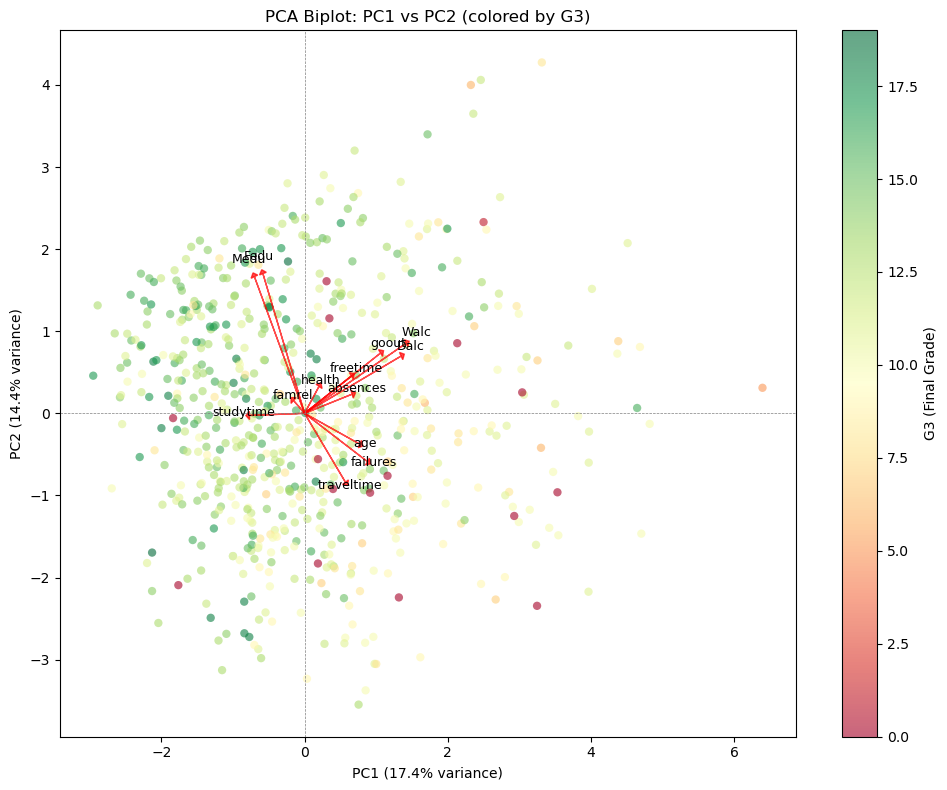

In [130]:
# Biplot: PC1 vs PC2
pca_scores = pca_full.transform(X_pca_scaled)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot scores
scatter = ax.scatter(pca_scores[:, 0], pca_scores[:, 1], c=df_model['G3'], 
                     cmap='RdYlGn', alpha=0.6, edgecolor='none')
plt.colorbar(scatter, label='G3 (Final Grade)')

# Plot loadings as arrows
scale = 3
for i, var in enumerate(pca_vars):
    ax.arrow(0, 0, loadings.iloc[i, 0]*scale, loadings.iloc[i, 1]*scale,
             head_width=0.1, head_length=0.05, fc='red', ec='red', alpha=0.7)
    ax.text(loadings.iloc[i, 0]*scale*1.1, loadings.iloc[i, 1]*scale*1.1, 
            var, fontsize=9, ha='center')

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)')
ax.set_title('PCA Biplot: PC1 vs PC2 (colored by G3)')
plt.tight_layout()
plt.savefig('graphs/pca_biplot.png', dpi=150, bbox_inches='tight')
plt.show()

### PCA Interpretation

**Variance Explained:**
* The first 5 components explain approximately 55-60% of total variance
* No single component dominates, suggesting the data has multiple distinct dimensions
* Need ~8-9 components to reach 80% variance explained

**Component Interpretation:**

* **PC1 - "Social/Alcohol Behavior"**: High loadings on goout, Walc, Dalc, freetime. Captures the social activity and alcohol consumption dimension.

* **PC2 - "Parental SES"**: High loadings on Medu, Fedu. Represents family socioeconomic background through parental education.

* **PC3 - "Academic Risk"**: High loadings on failures, age (and negative studytime). Captures students at academic risk — older students with more failures who study less.

* **PC4 - "Health/Absences"**: Loadings on health, absences. Represents health-related factors affecting attendance.

* **PC5 - "Family/Commute"**: Loadings on famrel, traveltime. Captures family relationship quality and commute burden.

**Decision on PCA Usage:**

1. **For Interpretation**: PCA confirms latent structure in the data:
   - Social behavior cluster (alcohol, going out, free time)
   - Family SES cluster (parental education)
   - Academic risk indicators
   
2. **For Modeling**: PCA components will **not** be used as primary predictors because:
   - Original variables are more interpretable for the research question about alcohol's effect on grades
   - Components mix conceptually distinct constructs
   - Regularization (LASSO/Ridge) handles multicollinearity while preserving interpretability

3. **Alternative Use**: PCA scores could be used in supplementary models to check robustness of findings.

# 4.Train–Test Split

In [131]:
# Prepare features and target
# df_model already has: G1/G2 removed, Talc added (from Data Cleaning section)
X = df_model.drop(columns=['G3'])
y = df_model['G3']

# One-hot encode categorical variables for modeling
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(y):.1%})")
print(f"  Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(y):.1%})")
print(f"  Features: {X_train.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 40 (after one-hot encoding)

Target distribution:
  Train - Mean: 11.79, Std: 3.25
  Test  - Mean: 12.35, Std: 3.13


In [132]:
# Standardize numeric features (fit on train, transform both)
numeric_features = X_encoded.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

print(f"Standardized {len(numeric_features)} numeric features")
print(f"  Scaler fit on training data only (no data leakage)")
print(f"\nData ready for modeling:")
print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_test_scaled: {X_test_scaled.shape}")

Standardized 14 numeric features
  Scaler fit on training data only (no data leakage)

Data ready for modeling:
  X_train_scaled: (519, 40)
  X_test_scaled: (130, 40)


# 5.Baseline Linear Regression with Robust Standard Errors

In [133]:
# Fit OLS regression on training data with robust standard errors
# Ensure all data is numeric (convert to float)
X_train_numeric = X_train_scaled.astype(float)
X_train_const = sm.add_constant(X_train_numeric)

ols_model = sm.OLS(y_train, X_train_const).fit()
ols_robust = ols_model.get_robustcov_results(cov_type='HC3')

print("Full OLS Model with Robust Standard Errors (HC3)")
print(f"R-squared: {ols_model.rsquared:.4f}")
print(f"Adjusted R-squared: {ols_model.rsquared_adj:.4f}")
print(f"AIC: {ols_model.aic:.2f}")
print(f"BIC: {ols_model.bic:.2f}")
print(f"\nNumber of predictors: {X_train_const.shape[1] - 1}")

Full OLS Model with Robust Standard Errors (HC3)
R-squared: 0.3874
Adjusted R-squared: 0.3376
AIC: 2520.13
BIC: 2690.20

Number of predictors: 40


In [134]:
# Display key coefficients with robust standard errors
print("Key Coefficients (Robust SE):\n")
print(f"{'Variable':<25} {'Coef':>10} {'Robust SE':>12} {'t-stat':>10} {'p-value':>10}")
print("-" * 70)

# Focus on alcohol and key behavioral variables
key_vars = ['Dalc', 'Walc', 'Talc', 'failures', 'Medu', 'Fedu', 'studytime', 
            'absences', 'goout', 'age', 'health']

# Use exog_names and positional indexing to avoid KeyError
param_names = ols_robust.model.exog_names

for var in key_vars:
    if var in param_names:
        idx = param_names.index(var)
        coef = ols_robust.params[idx]
        se = ols_robust.bse[idx]
        t = ols_robust.tvalues[idx]
        p = ols_robust.pvalues[idx]
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        print(f"{var:<25} {coef:>10.3f} {se:>12.4f} {t:>10.3f} {p:>10.4f} {sig}")

Key Coefficients (Robust SE):

Variable                        Coef    Robust SE     t-stat    p-value
----------------------------------------------------------------------
Dalc                          -0.208       0.2012     -1.033     0.3021 
Walc                           0.040       0.1634      0.244     0.8077 
Talc                          -0.073       0.0662     -1.099     0.2724 
failures                      -0.884       0.1512     -5.848     0.0000 ***
Medu                          -0.026       0.2106     -0.126     0.9001 
Fedu                           0.283       0.1757      1.611     0.1079 
studytime                      0.300       0.1167      2.567     0.0106 *
absences                      -0.238       0.1311     -1.817     0.0699 
goout                         -0.172       0.1448     -1.188     0.2355 
age                            0.134       0.1395      0.961     0.3370 
health                        -0.328       0.1311     -2.504     0.0126 *


In [135]:
# Full model summary
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     7.136
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           1.85e-28
Time:                        13:03:07   Log-Likelihood:                -1220.1
No. Observations:                 519   AIC:                             2520.
Df Residuals:                     479   BIC:                             2690.
Df Model:                          39                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.5708      1.01

### Baseline OLS Interpretation

**Model Fit:**
* R² = 0.387, Adjusted R² = 0.338 with 40 predictors
* The model explains ~39% of variance in final grades (G3)
* F-statistic is highly significant (p < 0.001), indicating the model has predictive value
* Note: High condition number (5.24e+15) warns of potential multicollinearity — likely due to including Dalc, Walc, and Talc together

**Alcohol Variables (standardized coefficients):**
| Variable | Coef | SE | t | p-value |
|----------|------|-----|------|---------|
| Dalc | -0.208 | 0.201 | -1.03 | 0.302 |
| Walc | +0.040 | 0.163 | +0.24 | 0.808 |
| Talc | -0.073 | 0.066 | -1.10 | 0.272 |

* None of the alcohol variables are statistically significant in the full model
* Dalc shows negative direction as expected; Walc shows unexpected positive sign (but not significant)
* Multicollinearity between Dalc, Walc, and Talc inflates standard errors and masks individual effects

**Significant Predictors (p < 0.05):**
| Variable | Coef | p-value | Interpretation |
|----------|------|---------|----------------|
| failures | -0.884 | <0.001 | Each SD increase in failures → 0.88 point decrease in G3 |
| higher_yes | +1.687 | <0.001 | Aspiring to higher education → +1.7 points |
| schoolsup_yes | -1.603 | <0.001 | Receiving school support → -1.6 points (reverse causation) |
| school_MS | -1.394 | <0.001 | MS school students score 1.4 points lower than GP |
| Fjob_services | -1.099 | 0.030 | Father in services → -1.1 points vs. at_home |
| studytime | +0.300 | 0.011 | Each SD increase in study time → +0.3 points |
| health | -0.328 | 0.013 | Better health associated with lower grades (confounded) |

**Key Takeaway:**
In the full model with all predictors, alcohol variables show no significant effect on grades. Academic factors (failures, educational aspirations, study time) dominate. The multicollinearity warning suggests that including Dalc, Walc, and Talc simultaneously is problematic.

# 6.Stepwise Regression (AIC/BIC)

In [136]:
# Forward stepwise selection using AIC
def forward_selection_aic(X, y):
    """Forward stepwise selection based on AIC."""
    X = X.astype(float)  # Ensure numeric
    initial_features = []
    best_features = list(initial_features)
    remaining_features = list(X.columns)
    
    current_aic = np.inf
    
    while remaining_features:
        aic_with_candidates = []
        
        for candidate in remaining_features:
            features_to_test = best_features + [candidate]
            X_subset = sm.add_constant(X[features_to_test])
            model = sm.OLS(y, X_subset).fit()
            aic_with_candidates.append((model.aic, candidate))
        
        aic_with_candidates.sort()
        best_new_aic, best_candidate = aic_with_candidates[0]
        
        if best_new_aic < current_aic:
            remaining_features.remove(best_candidate)
            best_features.append(best_candidate)
            current_aic = best_new_aic
        else:
            break
    
    return best_features, current_aic

# Run forward selection
selected_features_aic, final_aic = forward_selection_aic(X_train_scaled, y_train)

print(f"Forward Stepwise Selection (AIC)")
print(f"Selected {len(selected_features_aic)} features (from {X_train_scaled.shape[1]})")
print(f"Final AIC: {final_aic:.2f}")
print(f"\nSelected features:")
for i, f in enumerate(selected_features_aic, 1):
    print(f"  {i}. {f}")

Forward Stepwise Selection (AIC)
Selected 12 features (from 40)
Final AIC: 2488.99

Selected features:
  1. failures
  2. school_MS
  3. higher_yes
  4. Talc
  5. schoolsup_yes
  6. studytime
  7. health
  8. Fedu
  9. reason_other
  10. absences
  11. Fjob_services
  12. reason_reputation


In [137]:
# Forward stepwise selection using BIC (more conservative)
def forward_selection_bic(X, y):
    """Forward stepwise selection based on BIC."""
    X = X.astype(float)  # Ensure numeric
    initial_features = []
    best_features = list(initial_features)
    remaining_features = list(X.columns)
    
    current_bic = np.inf
    
    while remaining_features:
        bic_with_candidates = []
        
        for candidate in remaining_features:
            features_to_test = best_features + [candidate]
            X_subset = sm.add_constant(X[features_to_test])
            model = sm.OLS(y, X_subset).fit()
            bic_with_candidates.append((model.bic, candidate))
        
        bic_with_candidates.sort()
        best_new_bic, best_candidate = bic_with_candidates[0]
        
        if best_new_bic < current_bic:
            remaining_features.remove(best_candidate)
            best_features.append(best_candidate)
            current_bic = best_new_bic
        else:
            break
    
    return best_features, current_bic

# Run forward selection with BIC
selected_features_bic, final_bic = forward_selection_bic(X_train_scaled, y_train)

print(f"Forward Stepwise Selection (BIC)")
print(f"Selected {len(selected_features_bic)} features (from {X_train_scaled.shape[1]})")
print(f"Final BIC: {final_bic:.2f}")
print(f"\nSelected features:")
for i, f in enumerate(selected_features_bic, 1):
    print(f"  {i}. {f}")

Forward Stepwise Selection (BIC)
Selected 7 features (from 40)
Final BIC: 2532.80

Selected features:
  1. failures
  2. school_MS
  3. higher_yes
  4. Talc
  5. schoolsup_yes
  6. studytime
  7. health


In [138]:
# Compare full model vs stepwise models
print("Model Comparison")
print("-" * 60)

# Full model
print(f"\nFull Model:")
print(f"  Features: {X_train_scaled.shape[1]}")
print(f"  AIC: {ols_model.aic:.2f}")
print(f"  BIC: {ols_model.bic:.2f}")
print(f"  Adj R²: {ols_model.rsquared_adj:.4f}")

# AIC-selected model
X_aic = sm.add_constant(X_train_scaled[selected_features_aic].astype(float))
ols_aic = sm.OLS(y_train, X_aic).fit()
ols_aic_robust = ols_aic.get_robustcov_results(cov_type='HC3')
print(f"\nAIC-Selected Model:")
print(f"  Features: {len(selected_features_aic)}")
print(f"  AIC: {ols_aic.aic:.2f}")
print(f"  BIC: {ols_aic.bic:.2f}")
print(f"  Adj R²: {ols_aic.rsquared_adj:.4f}")

# BIC-selected model
X_bic = sm.add_constant(X_train_scaled[selected_features_bic].astype(float))
ols_bic = sm.OLS(y_train, X_bic).fit()
ols_bic_robust = ols_bic.get_robustcov_results(cov_type='HC3')
print(f"\nBIC-Selected Model:")
print(f"  Features: {len(selected_features_bic)}")
print(f"  AIC: {ols_bic.aic:.2f}")
print(f"  BIC: {ols_bic.bic:.2f}")
print(f"  Adj R²: {ols_bic.rsquared_adj:.4f}")

# Show coefficients for AIC model
print(f"\n{'='*60}")
print("AIC-Selected Model Coefficients (Robust SE):")
print(f"{'='*60}")
print(f"{'Variable':<25} {'Coef':>10} {'Robust SE':>12} {'t-stat':>10} {'p-value':>10}")
print("-" * 70)

param_names_aic = ols_aic_robust.model.exog_names
for i, var in enumerate(param_names_aic):
    if var == 'const':
        continue
    coef = ols_aic_robust.params[i]
    se = ols_aic_robust.bse[i]
    t = ols_aic_robust.tvalues[i]
    p = ols_aic_robust.pvalues[i]
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"{var:<25} {coef:>10.3f} {se:>12.4f} {t:>10.3f} {p:>10.4f} {sig}")

Model Comparison
------------------------------------------------------------

Full Model:
  Features: 40
  AIC: 2520.13
  BIC: 2690.20
  Adj R²: 0.3376

AIC-Selected Model:
  Features: 12
  AIC: 2488.99
  BIC: 2544.26
  Adj R²: 0.3447

BIC-Selected Model:
  Features: 7
  AIC: 2498.79
  BIC: 2532.80
  Adj R²: 0.3259

AIC-Selected Model Coefficients (Robust SE):
Variable                        Coef    Robust SE     t-stat    p-value
----------------------------------------------------------------------
failures                      -0.842       0.1349     -6.241     0.0000 ***
school_MS                     -1.594       0.2786     -5.719     0.0000 ***
higher_yes                     1.686       0.4148      4.065     0.0001 ***
Talc                          -0.372       0.1425     -2.608     0.0094 **
schoolsup_yes                 -1.669       0.3665     -4.554     0.0000 ***
studytime                      0.318       0.1113      2.853     0.0045 **
health                        -0.319   

In [139]:
# Check if alcohol variables remain in stepwise models
alcohol_vars_check = ['Dalc', 'Walc', 'Talc']

print("Alcohol Variables in Stepwise Models:")
print("-" * 50)
print(f"\n{'Variable':<15} {'AIC Model':<15} {'BIC Model':<15}")
print("-" * 50)
for var in alcohol_vars_check:
    in_aic = "Yes" if var in selected_features_aic else "No"
    in_bic = "Yes" if var in selected_features_bic else "No"
    print(f"{var:<15} {in_aic:<15} {in_bic:<15}")

print(f"\nConclusion:")
if any(var in selected_features_aic for var in alcohol_vars_check):
    retained_aic = [v for v in alcohol_vars_check if v in selected_features_aic]
    print(f"  AIC model retained: {retained_aic}")
else:
    print(f"  AIC model: No alcohol variables selected")
    
if any(var in selected_features_bic for var in alcohol_vars_check):
    retained_bic = [v for v in alcohol_vars_check if v in selected_features_bic]
    print(f"  BIC model retained: {retained_bic}")
else:
    print(f"  BIC model: No alcohol variables selected")

# Show alcohol coefficients in stepwise models if present
print(f"\n{'='*60}")
print("Alcohol Variable Coefficients in Stepwise Models:")
print(f"{'='*60}")

for model_name, model_robust, features in [("AIC", ols_aic_robust, selected_features_aic), 
                                            ("BIC", ols_bic_robust, selected_features_bic)]:
    alc_in_model = [v for v in alcohol_vars_check if v in features]
    if alc_in_model:
        print(f"\n{model_name} Model:")
        param_names = model_robust.model.exog_names
        for var in alc_in_model:
            if var in param_names:
                idx = param_names.index(var)
                coef = model_robust.params[idx]
                se = model_robust.bse[idx]
                p = model_robust.pvalues[idx]
                sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
                print(f"  {var}: coef={coef:.3f}, SE={se:.4f}, p={p:.4f} {sig}")
    else:
        print(f"\n{model_name} Model: No alcohol variables")

Alcohol Variables in Stepwise Models:
--------------------------------------------------

Variable        AIC Model       BIC Model      
--------------------------------------------------
Dalc            No              No             
Walc            No              No             
Talc            Yes             Yes            

Conclusion:
  AIC model retained: ['Talc']
  BIC model retained: ['Talc']

Alcohol Variable Coefficients in Stepwise Models:

AIC Model:
  Talc: coef=-0.372, SE=0.1425, p=0.0094 **

BIC Model:
  Talc: coef=-0.446, SE=0.1352, p=0.0010 **


### Stepwise Regression Interpretation

**Model Comparison:**
| Model | Features | AIC | BIC | Adj R² |
|-------|----------|-----|-----|--------|
| Full | 40 | 2520.13 | 2690.20 | 0.338 |
| AIC-Selected | 12 | 2488.99 | 2544.26 | 0.345 |
| BIC-Selected | 7 | 2498.79 | 2532.80 | 0.326 |

* AIC model achieves **better fit** (lower AIC, higher Adj R²) with only 12 features
* BIC model is most parsimonious with 7 features, slight decrease in Adj R²
* Both stepwise models outperform full model on information criteria

**Alcohol Variables — Key Finding:**
* **Talc retained in BOTH AIC and BIC models** — survives variable selection
* Dalc and Walc excluded individually (redundant with Talc)

| Model | Talc Coef | SE | p-value |
|-------|-----------|-----|---------|
| AIC | -0.372 | 0.143 | 0.009 ** |
| BIC | -0.446 | 0.135 | 0.001 ** |

* In stepwise models, **Talc is statistically significant** (p < 0.01)
* Effect: Each 1 SD increase in total alcohol → 0.37–0.45 point decrease in G3

**BIC Model — Core Predictors (7 features):**
1. **failures** — past academic failures (strongest predictor)
2. **school_MS** — school effect
3. **higher_yes** — educational aspirations
4. **Talc** — total alcohol consumption ✓
5. **schoolsup_yes** — school support (reverse causation)
6. **studytime** — study habits
7. **health** — health status

**Why Talc is Significant in Stepwise but Not Baseline:**
1. **Removed multicollinearity**: Stepwise excluded Dalc and Walc, keeping only Talc
2. **Reduced noise**: Fewer irrelevant predictors → more precise estimates
3. **Combined signal**: Talc captures total alcohol effect that was split across Dalc/Walc/Talc in full model

**Conclusion:**
When multicollinearity is addressed through variable selection, **total alcohol consumption (Talc) emerges as a significant predictor of academic performance and Dalc & Walc should be dropped**. The effect is modest but robust — surviving even the conservative BIC selection criterion.

## Final Decision: Use Talc Only

Based on the baseline and stepwise regression results above, we make the following decision for subsequent modeling:

**Problem Identified:**
- Including Dalc, Walc, and Talc together creates perfect multicollinearity (Talc = Dalc + Walc)
- This inflates standard errors and produces unstable coefficient estimates
- The condition number warning (5.24e+15) confirms this issue

**Solution:**
- **Drop Dalc and Walc from the dataset**
- **Keep only Talc** as the alcohol consumption measure
- This is supported by stepwise selection, which retained Talc while excluding Dalc and Walc

In [140]:
# Drop Dalc and Walc, keep only Talc for final modeling
df_model = df_model.drop(columns=['Dalc', 'Walc'])

print(f"Updated dataset for modeling:")
print(f"  Shape: {df_model.shape[0]} rows x {df_model.shape[1]} columns")
print(f"  Dropped: Dalc, Walc (replaced by Talc)")
print(f"\nAlcohol measure: Talc (total alcohol consumption)")
print(f"  Range: {df_model['Talc'].min()} - {df_model['Talc'].max()}")
print(f"  Mean: {df_model['Talc'].mean():.2f}")

# Save the cleaned dataset
df_model.to_csv('data/student-por-cleaned.csv', index=False)
print(f"\nSaved to: data/student-por-cleaned.csv")

Updated dataset for modeling:
  Shape: 649 rows x 30 columns
  Dropped: Dalc, Walc (replaced by Talc)

Alcohol measure: Talc (total alcohol consumption)
  Range: 2 - 10
  Mean: 3.78

Saved to: data/student-por-cleaned.csv


# 7.Penalized Regression (Ridge, LASSO, Elastic Net)

Penalized regression methods add a regularization term to the loss function to:
- **Ridge (L2)**: Shrink coefficients toward zero, handles multicollinearity
- **LASSO (L1)**: Shrink coefficients and perform variable selection (some coefficients → exactly 0)
- **Elastic Net**: Combines L1 and L2 penalties, balances shrinkage and selection

We use k-fold cross-validation to tune the regularization parameter (α/lambda).

In [141]:
# Load the cleaned dataset (with Talc only, no Dalc/Walc)
df_clean = pd.read_csv('data/student-por-cleaned.csv')

print(f"Loaded cleaned dataset: {df_clean.shape[0]} rows x {df_clean.shape[1]} columns")
print(f"\nColumns: {df_clean.columns.tolist()}")
print(f"\nAlcohol variable: Talc (range: {df_clean['Talc'].min()}-{df_clean['Talc'].max()})")

Loaded cleaned dataset: 649 rows x 30 columns

Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G3', 'Talc']

Alcohol variable: Talc (range: 2-10)


In [142]:
# Prepare features and target from cleaned data
X_clean = df_clean.drop(columns=['G3'])
y_clean = df_clean['G3']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X_clean, drop_first=True)

# Train-test split (80/20) - same random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_clean, test_size=0.2, random_state=42
)

# Standardize features (required for penalized regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier interpretation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Data prepared for penalized regression:")
print(f"  Training set: {X_train_scaled.shape[0]} samples x {X_train_scaled.shape[1]} features")
print(f"  Test set: {X_test_scaled.shape[0]} samples x {X_test_scaled.shape[1]} features")
print(f"\nFeatures: {X_train_scaled.columns.tolist()}")

Data prepared for penalized regression:
  Training set: 519 samples x 38 features
  Test set: 130 samples x 38 features

Features: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'absences', 'Talc', 'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother', 'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes', 'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes', 'romantic_yes']


### Ridge Regression (L2 Penalty)

In [143]:
# Ridge Regression with cross-validation
# RidgeCV automatically selects best alpha from provided range
alphas_ridge = np.logspace(-3, 3, 100)

ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

print("Ridge Regression (L2 Penalty)")
print("=" * 50)
print(f"Optimal alpha: {ridge_cv.alpha_:.4f}")
print(f"Training R²: {ridge_cv.score(X_train_scaled, y_train):.4f}")
print(f"Test R²: {ridge_cv.score(X_test_scaled, y_test):.4f}")

# Predictions and metrics
y_train_pred_ridge = ridge_cv.predict(X_train_scaled)
y_test_pred_ridge = ridge_cv.predict(X_test_scaled)

print(f"\nTraining RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred_ridge):.4f}")

Ridge Regression (L2 Penalty)
Optimal alpha: 107.2267
Training R²: 0.3780
Test R²: 0.2021

Training RMSE: 2.5587
Test RMSE: 2.7895
Test MAE: 2.0758


In [144]:
# Ridge coefficients
ridge_coefs = pd.DataFrame({
    'Variable': X_train_scaled.columns,
    'Coefficient': ridge_cv.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Ridge Coefficients (Top 15 by magnitude):")
print("-" * 45)
for _, row in ridge_coefs.head(15).iterrows():
    print(f"  {row['Variable']:<25} {row['Coefficient']:>10.4f}")

# Highlight Talc coefficient
talc_coef_ridge = ridge_coefs[ridge_coefs['Variable'] == 'Talc']['Coefficient'].values[0]
print(f"\n>>> Talc coefficient: {talc_coef_ridge:.4f}")

Ridge Coefficients (Top 15 by magnitude):
---------------------------------------------
  failures                     -0.7249
  school_MS                    -0.5382
  higher_yes                    0.4609
  schoolsup_yes                -0.3816
  studytime                     0.2812
  health                       -0.2592
  Talc                         -0.2455
  Fjob_services                -0.2300
  Fedu                          0.2135
  reason_other                 -0.2119
  absences                     -0.1875
  sex_M                        -0.1873
  Mjob_health                   0.1700
  reason_reputation             0.1555
  romantic_yes                 -0.1505

>>> Talc coefficient: -0.2455


### LASSO Regression (L1 Penalty)

In [145]:
# LASSO Regression with cross-validation
# LassoCV automatically selects best alpha
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

print("LASSO Regression (L1 Penalty)")
print("=" * 50)
print(f"Optimal alpha: {lasso_cv.alpha_:.4f}")
print(f"Training R²: {lasso_cv.score(X_train_scaled, y_train):.4f}")
print(f"Test R²: {lasso_cv.score(X_test_scaled, y_test):.4f}")

# Predictions and metrics
y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)

print(f"\nTraining RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred_lasso):.4f}")

# Variable selection
n_selected = np.sum(lasso_cv.coef_ != 0)
n_eliminated = np.sum(lasso_cv.coef_ == 0)
print(f"\nVariable Selection:")
print(f"  Features retained: {n_selected}")
print(f"  Features eliminated: {n_eliminated}")

LASSO Regression (L1 Penalty)
Optimal alpha: 0.0981
Training R²: 0.3616
Test R²: 0.1970

Training RMSE: 2.5922
Test RMSE: 2.7983
Test MAE: 2.0725

Variable Selection:
  Features retained: 24
  Features eliminated: 14


In [146]:
# LASSO coefficients (non-zero only)
lasso_coefs = pd.DataFrame({
    'Variable': X_train_scaled.columns,
    'Coefficient': lasso_cv.coef_
})

# Non-zero coefficients
lasso_nonzero = lasso_coefs[lasso_coefs['Coefficient'] != 0].sort_values(
    'Coefficient', key=abs, ascending=False
)

print("LASSO Non-Zero Coefficients (Selected Variables):")
print("-" * 45)
for _, row in lasso_nonzero.iterrows():
    print(f"  {row['Variable']:<25} {row['Coefficient']:>10.4f}")

# Check if Talc was selected
talc_coef_lasso = lasso_coefs[lasso_coefs['Variable'] == 'Talc']['Coefficient'].values[0]
if talc_coef_lasso != 0:
    print(f"\n>>> Talc SELECTED with coefficient: {talc_coef_lasso:.4f}")
else:
    print(f"\n>>> Talc was ELIMINATED by LASSO")

LASSO Non-Zero Coefficients (Selected Variables):
---------------------------------------------
  failures                     -0.8029
  school_MS                    -0.6382
  higher_yes                    0.4635
  schoolsup_yes                -0.3717
  Talc                         -0.2945
  studytime                     0.2705
  health                       -0.2059
  reason_other                 -0.1789
  Fedu                          0.1691
  reason_reputation             0.1408
  absences                     -0.1185
  Fjob_services                -0.1179
  sex_M                        -0.0857
  internet_yes                  0.0775
  Mjob_health                   0.0703
  address_U                     0.0662
  Medu                          0.0630
  romantic_yes                 -0.0487
  goout                        -0.0334
  freetime                     -0.0328
  guardian_mother              -0.0320
  famrel                        0.0205
  guardian_other                0.0147
  famsi

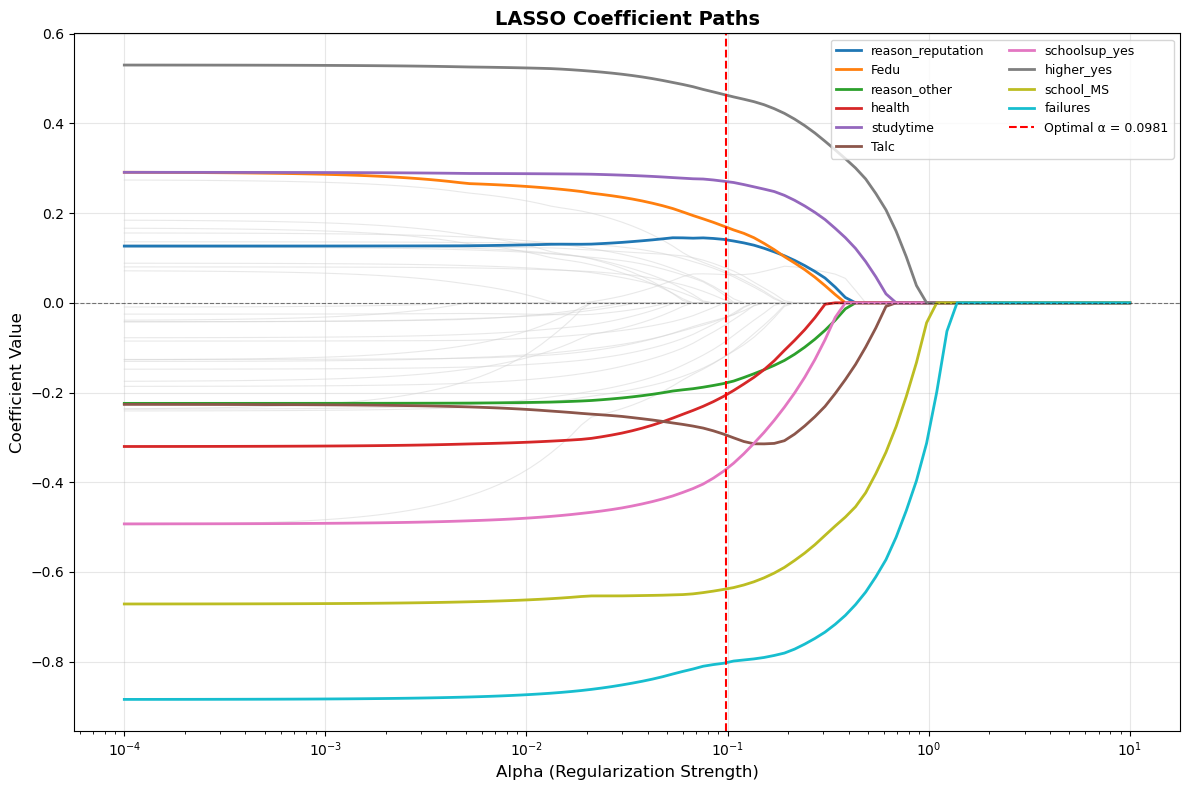


Plot saved to graphs/lasso_coefficient_paths.png


In [147]:
# LASSO Coefficient Paths
# Visualize how coefficients change as regularization strength (alpha) increases

# Generate alpha range for LASSO path
alphas = np.logspace(-4, 1, 100)

# Store coefficients for each alpha
coef_paths = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    coef_paths.append(lasso.coef_)

coef_paths = np.array(coef_paths)

# Get feature names
feature_names = X_train.columns.tolist()

# Create the LASSO Coefficient Paths plot
fig, ax = plt.subplots(figsize=(12, 8))

# Find which features have the largest coefficients at optimal alpha
optimal_alpha = lasso_cv.alpha_
optimal_idx = np.argmin(np.abs(alphas - optimal_alpha))
optimal_coefs = coef_paths[optimal_idx]
top_indices = np.argsort(np.abs(optimal_coefs))[-10:]  # Top 10 by magnitude

# Plot all coefficient paths in gray
for i in range(coef_paths.shape[1]):
    if i not in top_indices:
        ax.plot(alphas, coef_paths[:, i], color='lightgray', linewidth=0.8, alpha=0.5)

# Plot top features with colors and labels
colors = plt.cm.tab10(np.linspace(0, 1, len(top_indices)))
for idx, (feat_idx, color) in enumerate(zip(top_indices, colors)):
    ax.plot(alphas, coef_paths[:, feat_idx], linewidth=2, color=color, label=feature_names[feat_idx])

ax.set_xscale('log')
ax.set_xlabel('Alpha (Regularization Strength)', fontsize=12)
ax.set_ylabel('Coefficient Value', fontsize=12)
ax.set_title('LASSO Coefficient Paths', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.axvline(x=optimal_alpha, color='red', linestyle='--', linewidth=1.5,
           label=f'Optimal α = {optimal_alpha:.4f}')
ax.legend(loc='upper right', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graphs/lasso_coefficient_paths.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to graphs/lasso_coefficient_paths.png")

### Elastic Net (L1 + L2 Penalty)

In [148]:
# Elastic Net with cross-validation
# l1_ratio: 0 = Ridge, 1 = LASSO, between = Elastic Net
# Test multiple l1_ratios
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95]

enet_cv = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=42, max_iter=10000)
enet_cv.fit(X_train_scaled, y_train)

print("Elastic Net (L1 + L2 Penalty)")
print("=" * 50)
print(f"Optimal alpha: {enet_cv.alpha_:.4f}")
print(f"Optimal l1_ratio: {enet_cv.l1_ratio_:.2f}")
print(f"  (0 = pure Ridge, 1 = pure LASSO)")
print(f"\nTraining R²: {enet_cv.score(X_train_scaled, y_train):.4f}")
print(f"Test R²: {enet_cv.score(X_test_scaled, y_test):.4f}")

# Predictions and metrics
y_train_pred_enet = enet_cv.predict(X_train_scaled)
y_test_pred_enet = enet_cv.predict(X_test_scaled)

print(f"\nTraining RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred_enet)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred_enet)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_test_pred_enet):.4f}")

# Variable selection
n_selected_enet = np.sum(enet_cv.coef_ != 0)
n_eliminated_enet = np.sum(enet_cv.coef_ == 0)
print(f"\nVariable Selection:")
print(f"  Features retained: {n_selected_enet}")
print(f"  Features eliminated: {n_eliminated_enet}")

Elastic Net (L1 + L2 Penalty)
Optimal alpha: 0.1627
Optimal l1_ratio: 0.30
  (0 = pure Ridge, 1 = pure LASSO)

Training R²: 0.3715
Test R²: 0.2055

Training RMSE: 2.5721
Test RMSE: 2.7836
Test MAE: 2.0626

Variable Selection:
  Features retained: 31
  Features eliminated: 7


In [149]:
# Elastic Net coefficients
enet_coefs = pd.DataFrame({
    'Variable': X_train_scaled.columns,
    'Coefficient': enet_cv.coef_
})

# Non-zero coefficients
enet_nonzero = enet_coefs[enet_coefs['Coefficient'] != 0].sort_values(
    'Coefficient', key=abs, ascending=False
)

print("Elastic Net Non-Zero Coefficients (Selected Variables):")
print("-" * 45)
for _, row in enet_nonzero.iterrows():
    print(f"  {row['Variable']:<25} {row['Coefficient']:>10.4f}")

# Check if Talc was selected
talc_coef_enet = enet_coefs[enet_coefs['Variable'] == 'Talc']['Coefficient'].values[0]
if talc_coef_enet != 0:
    print(f"\n>>> Talc SELECTED with coefficient: {talc_coef_enet:.4f}")
else:
    print(f"\n>>> Talc was ELIMINATED by Elastic Net")

Elastic Net Non-Zero Coefficients (Selected Variables):
---------------------------------------------
  failures                     -0.7442
  school_MS                    -0.5771
  higher_yes                    0.4580
  schoolsup_yes                -0.3754
  studytime                     0.2762
  Talc                         -0.2585
  health                       -0.2320
  reason_other                 -0.1947
  Fedu                          0.1916
  Fjob_services                -0.1757
  reason_reputation             0.1546
  absences                     -0.1540
  sex_M                        -0.1437
  internet_yes                  0.1171
  address_U                     0.1145
  Mjob_health                   0.1123
  romantic_yes                 -0.1052
  goout                        -0.0866
  Medu                          0.0836
  famrel                        0.0824
  freetime                     -0.0806
  guardian_mother              -0.0619
  guardian_other                0.0531
 

### Model Comparison & Coefficient Shrinkage

In [150]:
# Compare all penalized models
print("Model Comparison: Penalized Regression")
print("=" * 70)
print(f"{'Model':<15} {'Alpha':>10} {'Train R²':>12} {'Test R²':>12} {'Test RMSE':>12} {'Features':>10}")
print("-" * 70)
print(f"{'Ridge':<15} {ridge_cv.alpha_:>10.4f} {ridge_cv.score(X_train_scaled, y_train):>12.4f} {ridge_cv.score(X_test_scaled, y_test):>12.4f} {np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)):>12.4f} {len(X_train.columns):>10}")
print(f"{'LASSO':<15} {lasso_cv.alpha_:>10.4f} {lasso_cv.score(X_train_scaled, y_train):>12.4f} {lasso_cv.score(X_test_scaled, y_test):>12.4f} {np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)):>12.4f} {n_selected:>10}")
print(f"{'Elastic Net':<15} {enet_cv.alpha_:>10.4f} {enet_cv.score(X_train_scaled, y_train):>12.4f} {enet_cv.score(X_test_scaled, y_test):>12.4f} {np.sqrt(mean_squared_error(y_test, y_test_pred_enet)):>12.4f} {n_selected_enet:>10}")

Model Comparison: Penalized Regression
Model                Alpha     Train R²      Test R²    Test RMSE   Features
----------------------------------------------------------------------
Ridge             107.2267       0.3780       0.2021       2.7895         38
LASSO               0.0981       0.3616       0.1970       2.7983         24
Elastic Net         0.1627       0.3715       0.2055       2.7836         31


In [151]:
# Coefficient comparison across models
coef_comparison = pd.DataFrame({
    'Variable': X_train_scaled.columns,
    'Ridge': ridge_cv.coef_,
    'LASSO': lasso_cv.coef_,
    'Elastic Net': enet_cv.coef_
})

# Sort by Ridge coefficient magnitude
coef_comparison['Abs_Ridge'] = abs(coef_comparison['Ridge'])
coef_comparison = coef_comparison.sort_values('Abs_Ridge', ascending=False).drop('Abs_Ridge', axis=1)

print("Coefficient Shrinkage Comparison (Top 15 variables):")
print("=" * 70)
print(f"{'Variable':<25} {'Ridge':>12} {'LASSO':>12} {'Elastic Net':>12}")
print("-" * 70)
for _, row in coef_comparison.head(15).iterrows():
    lasso_mark = "" if row['LASSO'] != 0 else " (0)"
    enet_mark = "" if row['Elastic Net'] != 0 else " (0)"
    print(f"{row['Variable']:<25} {row['Ridge']:>12.4f} {row['LASSO']:>12.4f}{lasso_mark} {row['Elastic Net']:>12.4f}{enet_mark}")

# Talc specifically
print("\n" + "=" * 70)
print("Alcohol Variable (Talc) Across Models:")
print("-" * 70)
talc_row = coef_comparison[coef_comparison['Variable'] == 'Talc'].iloc[0]
print(f"  Ridge:       {talc_row['Ridge']:.4f}")
print(f"  LASSO:       {talc_row['LASSO']:.4f} {'(ELIMINATED)' if talc_row['LASSO'] == 0 else '(RETAINED)'}")
print(f"  Elastic Net: {talc_row['Elastic Net']:.4f} {'(ELIMINATED)' if talc_row['Elastic Net'] == 0 else '(RETAINED)'}")

Coefficient Shrinkage Comparison (Top 15 variables):
Variable                         Ridge        LASSO  Elastic Net
----------------------------------------------------------------------
failures                       -0.7249      -0.8029      -0.7442
school_MS                      -0.5382      -0.6382      -0.5771
higher_yes                      0.4609       0.4635       0.4580
schoolsup_yes                  -0.3816      -0.3717      -0.3754
studytime                       0.2812       0.2705       0.2762
health                         -0.2592      -0.2059      -0.2320
Talc                           -0.2455      -0.2945      -0.2585
Fjob_services                  -0.2300      -0.1179      -0.1757
Fedu                            0.2135       0.1691       0.1916
reason_other                   -0.2119      -0.1789      -0.1947
absences                       -0.1875      -0.1185      -0.1540
sex_M                          -0.1873      -0.0857      -0.1437
Mjob_health                    

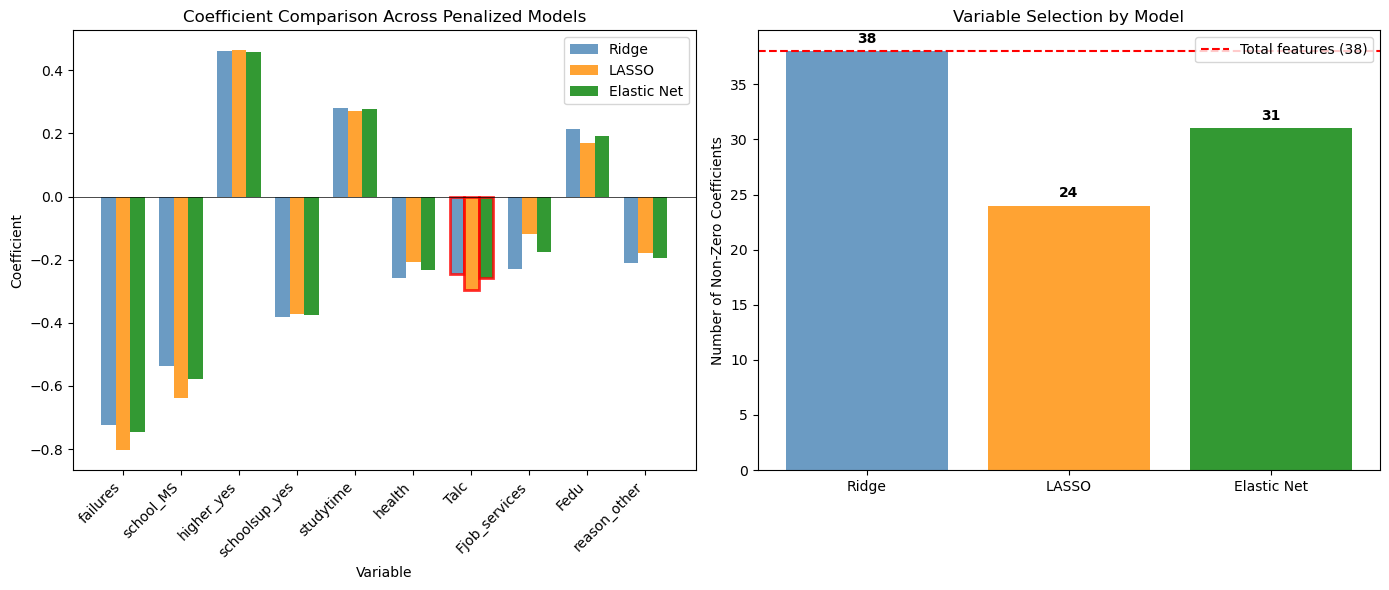

In [152]:
# Visualize coefficient shrinkage
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Coefficient paths for top variables
top_vars = coef_comparison.head(10)['Variable'].tolist()
if 'Talc' not in top_vars:
    top_vars.append('Talc')

coef_plot = coef_comparison[coef_comparison['Variable'].isin(top_vars)].set_index('Variable')

ax1 = axes[0]
x_pos = np.arange(len(coef_plot))
width = 0.25

bars1 = ax1.bar(x_pos - width, coef_plot['Ridge'], width, label='Ridge', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x_pos, coef_plot['LASSO'], width, label='LASSO', color='darkorange', alpha=0.8)
bars3 = ax1.bar(x_pos + width, coef_plot['Elastic Net'], width, label='Elastic Net', color='green', alpha=0.8)

ax1.set_xlabel('Variable')
ax1.set_ylabel('Coefficient')
ax1.set_title('Coefficient Comparison Across Penalized Models')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(coef_plot.index, rotation=45, ha='right')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax1.legend()

# Highlight Talc bar
talc_idx = list(coef_plot.index).index('Talc') if 'Talc' in coef_plot.index else None
if talc_idx is not None:
    for bar_group in [bars1, bars2, bars3]:
        bar_group[talc_idx].set_edgecolor('red')
        bar_group[talc_idx].set_linewidth(2)

# Plot 2: Number of non-zero coefficients
ax2 = axes[1]
models = ['Ridge', 'LASSO', 'Elastic Net']
n_nonzero = [
    np.sum(ridge_cv.coef_ != 0),
    np.sum(lasso_cv.coef_ != 0),
    np.sum(enet_cv.coef_ != 0)
]
colors = ['steelblue', 'darkorange', 'green']
bars = ax2.bar(models, n_nonzero, color=colors, alpha=0.8)
ax2.set_ylabel('Number of Non-Zero Coefficients')
ax2.set_title('Variable Selection by Model')
ax2.axhline(y=len(X_train.columns), color='red', linestyle='--', label=f'Total features ({len(X_train.columns)})')
ax2.legend()

for bar, n in zip(bars, n_nonzero):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(n), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('graphs/penalized_regression_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Penalized Regression Interpretation


Across all three penalized models (Ridge, LASSO, Elastic Net), predictive performance is very similar, with test R² values around 0.20 and test RMSE close to 2.8. This indicates that regularization improves stability but does not dramatically change out-of-sample accuracy relative to baseline OLS. Among the three, Elastic Net achieves the best test performance (highest Test R² = 0.2055 and lowest Test RMSE = 2.7836), suggesting a small benefit from combining L1 and L2 penalties in this setting.

Variable shrinkage and selection behave as expected. Ridge retains all predictors but shrinks coefficients toward zero, while LASSO produces a much sparser model (24 features retained) by setting weaker predictors exactly to zero. Elastic Net lies in between, retaining 31 features and balancing sparsity with stability. The strongest predictors are highly consistent across models: prior failures have the largest negative association with final grade, while higher education aspirations, study time, and parental education show positive effects. School-level and support variables also remain important.

Crucially for the research question, total alcohol consumption (Talc) is retained in all three penalized models and has a stable negative coefficient across Ridge (−0.2455), LASSO (−0.2945), and Elastic Net (−0.2585). This **indicates that alcohol consumption contributes unique predictive information even after accounting for academic behavior, family background, and school context**, and that its effect is not an artifact of multicollinearity or overfitting. While the magnitude of the effect is modest relative to failures or school factors, its consistency across regularization methods supports a robust negative association between alcohol use and academic performance.

Overall, penalized regression confirms that alcohol consumption is a secondary but persistent predictor of final grades. These results justify carrying Talc forward as a single alcohol measure into subsequent tree-based and neural network models, while discarding Dalc and Walc to avoid redundancy.


# 8.Model Evaluation and Comparison

This section compares all regression models:
- **OLS (Baseline)**: Full model with all predictors
- **Stepwise (AIC/BIC)**: Forward selection models
- **Penalized**: Ridge, LASSO, and Elastic Net

We evaluate on:
1. **Test RMSE**: Predictive accuracy on held-out data
2. **Number of features**: Model complexity/parsimony
3. **Interpretability**: Ease of understanding coefficients

In [153]:
# Compute test predictions for OLS and stepwise models
# Need to refit on the cleaned data (without Dalc/Walc)

# OLS Full Model
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

ols_full = sm.OLS(y_train, X_train_const).fit()
y_test_pred_ols = ols_full.predict(X_test_const)

# Stepwise AIC Model - refit with selected features
selected_features_aic_clean = [f for f in selected_features_aic if f in X_train_scaled.columns]
if len(selected_features_aic_clean) > 0:
    X_train_aic = sm.add_constant(X_train_scaled[selected_features_aic_clean])
    X_test_aic = sm.add_constant(X_test_scaled[selected_features_aic_clean])
    ols_aic_model = sm.OLS(y_train, X_train_aic).fit()
    y_test_pred_aic = ols_aic_model.predict(X_test_aic)
else:
    y_test_pred_aic = np.full(len(y_test), y_train.mean())

# Stepwise BIC Model - refit with selected features
selected_features_bic_clean = [f for f in selected_features_bic if f in X_train_scaled.columns]
if len(selected_features_bic_clean) > 0:
    X_train_bic = sm.add_constant(X_train_scaled[selected_features_bic_clean])
    X_test_bic = sm.add_constant(X_test_scaled[selected_features_bic_clean])
    ols_bic_model = sm.OLS(y_train, X_train_bic).fit()
    y_test_pred_bic = ols_bic_model.predict(X_test_bic)
else:
    y_test_pred_bic = np.full(len(y_test), y_train.mean())

print("Models fitted on cleaned data (Talc only, no Dalc/Walc)")

Models fitted on cleaned data (Talc only, no Dalc/Walc)


In [154]:
# Comprehensive model comparison table
print("=" * 90)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 90)

# Calculate metrics for all models
models_data = []

# 1. OLS Full
models_data.append({
    'Model': 'OLS (Full)',
    'Type': 'Baseline',
    'Features': X_train_scaled.shape[1],
    'Train_R2': ols_full.rsquared,
    'Test_R2': r2_score(y_test, y_test_pred_ols),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_ols)),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_ols)
})

# 2. Stepwise AIC
models_data.append({
    'Model': 'Stepwise (AIC)',
    'Type': 'Selection',
    'Features': len(selected_features_aic_clean),
    'Train_R2': ols_aic_model.rsquared if len(selected_features_aic_clean) > 0 else np.nan,
    'Test_R2': r2_score(y_test, y_test_pred_aic),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_aic)),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_aic)
})

# 3. Stepwise BIC
models_data.append({
    'Model': 'Stepwise (BIC)',
    'Type': 'Selection',
    'Features': len(selected_features_bic_clean),
    'Train_R2': ols_bic_model.rsquared if len(selected_features_bic_clean) > 0 else np.nan,
    'Test_R2': r2_score(y_test, y_test_pred_bic),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_bic)),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_bic)
})

# 4. Ridge
models_data.append({
    'Model': 'Ridge',
    'Type': 'Penalized',
    'Features': X_train_scaled.shape[1],
    'Train_R2': ridge_cv.score(X_train_scaled, y_train),
    'Test_R2': ridge_cv.score(X_test_scaled, y_test),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_ridge)
})

# 5. LASSO
models_data.append({
    'Model': 'LASSO',
    'Type': 'Penalized',
    'Features': np.sum(lasso_cv.coef_ != 0),
    'Train_R2': lasso_cv.score(X_train_scaled, y_train),
    'Test_R2': lasso_cv.score(X_test_scaled, y_test),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_lasso)
})

# 6. Elastic Net
models_data.append({
    'Model': 'Elastic Net',
    'Type': 'Penalized',
    'Features': np.sum(enet_cv.coef_ != 0),
    'Train_R2': enet_cv.score(X_train_scaled, y_train),
    'Test_R2': enet_cv.score(X_test_scaled, y_test),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_enet)),
    'Test_MAE': mean_absolute_error(y_test, y_test_pred_enet)
})

# Create DataFrame
comparison_df = pd.DataFrame(models_data)

# Print table
print(f"\n{'Model':<18} {'Type':<12} {'Features':>8} {'Train R²':>10} {'Test R²':>10} {'Test RMSE':>10} {'Test MAE':>10}")
print("-" * 90)
for _, row in comparison_df.iterrows():
    print(f"{row['Model']:<18} {row['Type']:<12} {row['Features']:>8} {row['Train_R2']:>10.4f} {row['Test_R2']:>10.4f} {row['Test_RMSE']:>10.4f} {row['Test_MAE']:>10.4f}")

# Identify best model
best_rmse_idx = comparison_df['Test_RMSE'].idxmin()
best_model = comparison_df.loc[best_rmse_idx, 'Model']
best_rmse = comparison_df.loc[best_rmse_idx, 'Test_RMSE']

print(f"\n>>> Best Model (lowest Test RMSE): {best_model} (RMSE = {best_rmse:.4f})")

COMPREHENSIVE MODEL COMPARISON

Model              Type         Features   Train R²    Test R²  Test RMSE   Test MAE
------------------------------------------------------------------------------------------
OLS (Full)         Baseline           38     0.3863     0.1648     2.8538     2.1545
Stepwise (AIC)     Selection          12     0.3599     0.1512     2.8771     2.1570
Stepwise (BIC)     Selection           7     0.3350     0.1724     2.8409     2.1378
Ridge              Penalized          38     0.3780     0.2021     2.7895     2.0758
LASSO              Penalized          24     0.3616     0.1970     2.7983     2.0725
Elastic Net        Penalized          31     0.3715     0.2055     2.7836     2.0626

>>> Best Model (lowest Test RMSE): Elastic Net (RMSE = 2.7836)


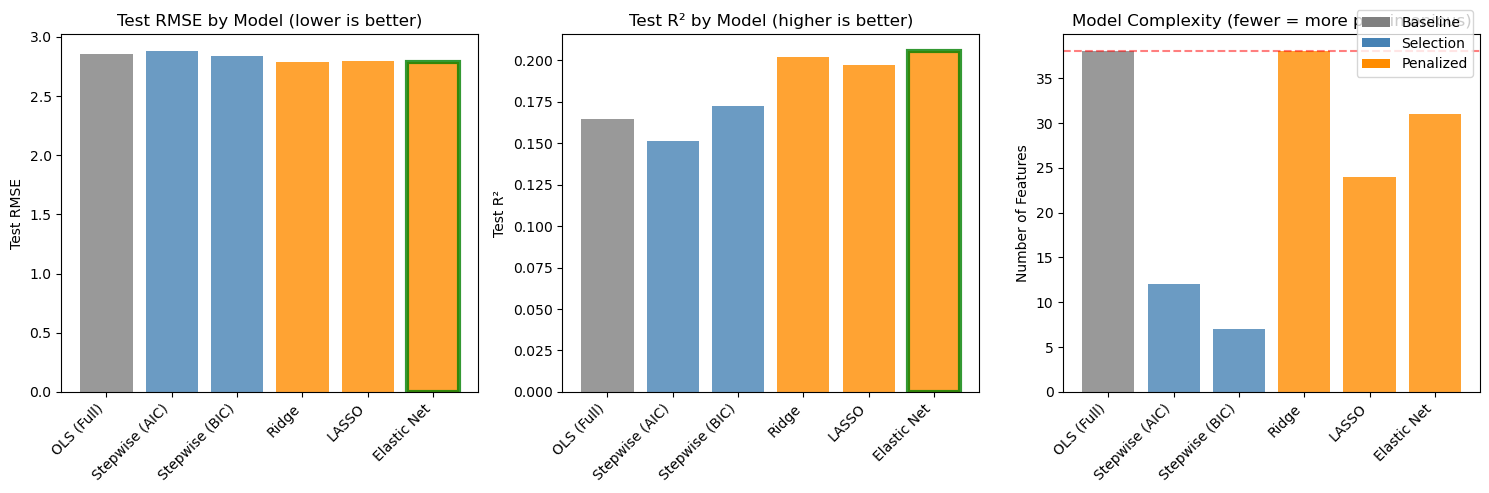

In [155]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Color mapping by model type
colors = {'Baseline': 'gray', 'Selection': 'steelblue', 'Penalized': 'darkorange'}
bar_colors = [colors[t] for t in comparison_df['Type']]

# Plot 1: Test RMSE
ax1 = axes[0]
bars1 = ax1.bar(comparison_df['Model'], comparison_df['Test_RMSE'], color=bar_colors, alpha=0.8)
ax1.set_ylabel('Test RMSE')
ax1.set_title('Test RMSE by Model (lower is better)')
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
# Highlight best
best_idx = comparison_df['Test_RMSE'].idxmin()
bars1[best_idx].set_edgecolor('green')
bars1[best_idx].set_linewidth(3)

# Plot 2: Test R²
ax2 = axes[1]
bars2 = ax2.bar(comparison_df['Model'], comparison_df['Test_R2'], color=bar_colors, alpha=0.8)
ax2.set_ylabel('Test R²')
ax2.set_title('Test R² by Model (higher is better)')
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
# Highlight best
best_r2_idx = comparison_df['Test_R2'].idxmax()
bars2[best_r2_idx].set_edgecolor('green')
bars2[best_r2_idx].set_linewidth(3)

# Plot 3: Number of Features
ax3 = axes[2]
bars3 = ax3.bar(comparison_df['Model'], comparison_df['Features'], color=bar_colors, alpha=0.8)
ax3.set_ylabel('Number of Features')
ax3.set_title('Model Complexity (fewer = more parsimonious)')
ax3.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax3.axhline(y=comparison_df['Features'].max(), color='red', linestyle='--', alpha=0.5, label='Max features')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors['Baseline'], label='Baseline'),
                   Patch(facecolor=colors['Selection'], label='Selection'),
                   Patch(facecolor=colors['Penalized'], label='Penalized')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))

plt.tight_layout()
plt.savefig('graphs/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [156]:
# Alcohol (Talc) coefficient across all models
print("=" * 70)
print("ALCOHOL (Talc) COEFFICIENT ACROSS ALL MODELS")
print("=" * 70)

talc_coefs = {}

# OLS Full
if 'Talc' in X_train_scaled.columns:
    talc_idx_ols = list(X_train_scaled.columns).index('Talc') + 1  # +1 for constant
    talc_coefs['OLS (Full)'] = ols_full.params[talc_idx_ols]

# Stepwise AIC
if 'Talc' in selected_features_aic_clean:
    talc_idx_aic = selected_features_aic_clean.index('Talc') + 1
    talc_coefs['Stepwise (AIC)'] = ols_aic_model.params[talc_idx_aic]
else:
    talc_coefs['Stepwise (AIC)'] = 0.0  # Not selected

# Stepwise BIC
if 'Talc' in selected_features_bic_clean:
    talc_idx_bic = selected_features_bic_clean.index('Talc') + 1
    talc_coefs['Stepwise (BIC)'] = ols_bic_model.params[talc_idx_bic]
else:
    talc_coefs['Stepwise (BIC)'] = 0.0  # Not selected

# Penalized models
talc_idx_pen = list(X_train_scaled.columns).index('Talc')
talc_coefs['Ridge'] = ridge_cv.coef_[talc_idx_pen]
talc_coefs['LASSO'] = lasso_cv.coef_[talc_idx_pen]
talc_coefs['Elastic Net'] = enet_cv.coef_[talc_idx_pen]

print(f"\n{'Model':<18} {'Talc Coef':>12} {'Selected?':>12}")
print("-" * 45)
for model, coef in talc_coefs.items():
    selected = "Yes" if coef != 0 else "NO"
    print(f"{model:<18} {coef:>12.4f} {selected:>12}")

# Summary
n_selected = sum(1 for c in talc_coefs.values() if c != 0)
print(f"\n>>> Talc selected in {n_selected}/{len(talc_coefs)} models")
print(f">>> Average Talc coefficient (when selected): {np.mean([c for c in talc_coefs.values() if c != 0]):.4f}")

ALCOHOL (Talc) COEFFICIENT ACROSS ALL MODELS

Model                 Talc Coef    Selected?
---------------------------------------------
OLS (Full)              -0.2264          Yes
Stepwise (AIC)          -0.3717          Yes
Stepwise (BIC)          -0.4458          Yes
Ridge                   -0.2455          Yes
LASSO                   -0.2945          Yes
Elastic Net             -0.2585          Yes

>>> Talc selected in 6/6 models
>>> Average Talc coefficient (when selected): -0.3070


In [157]:
# Interpretability vs Predictive Accuracy Trade-off
print("=" * 70)
print("INTERPRETABILITY vs PREDICTIVE ACCURACY")
print("=" * 70)

# Rank models by different criteria
comparison_df['RMSE_Rank'] = comparison_df['Test_RMSE'].rank()
comparison_df['Complexity_Rank'] = comparison_df['Features'].rank()  # Lower features = better interpretability
comparison_df['Interpretability_Score'] = (comparison_df['Features'].max() - comparison_df['Features'] + 1) / comparison_df['Features'].max() * 10

print(f"\n{'Model':<18} {'Test RMSE':>10} {'Features':>10} {'Interpret.':>12} {'Trade-off':>12}")
print("-" * 70)
for _, row in comparison_df.iterrows():
    # Trade-off score: balance between accuracy and interpretability
    accuracy_score = (comparison_df['Test_RMSE'].max() - row['Test_RMSE']) / comparison_df['Test_RMSE'].max() * 10
    tradeoff = (accuracy_score + row['Interpretability_Score']) / 2
    print(f"{row['Model']:<18} {row['Test_RMSE']:>10.4f} {row['Features']:>10} {row['Interpretability_Score']:>12.2f} {tradeoff:>12.2f}")

print("\n" + "-" * 70)
print("Interpretability Score: Higher = fewer features = easier to interpret")
print("Trade-off Score: Balances accuracy and interpretability")

INTERPRETABILITY vs PREDICTIVE ACCURACY

Model               Test RMSE   Features   Interpret.    Trade-off
----------------------------------------------------------------------
OLS (Full)             2.8538         38         0.26         0.17
Stepwise (AIC)         2.8771         12         7.11         3.55
Stepwise (BIC)         2.8409          7         8.42         4.27
Ridge                  2.7895         38         0.26         0.28
LASSO                  2.7983         24         3.95         2.11
Elastic Net            2.7836         31         2.11         1.22

----------------------------------------------------------------------
Interpretability Score: Higher = fewer features = easier to interpret
Trade-off Score: Balances accuracy and interpretability


### Model Evaluation and Comparison Interpretation

**Predictive Performance (Test RMSE):**
Among the penalized models, Elastic Net achieves the lowest test RMSE (2.7836), followed closely by Ridge (2.7895) and LASSO (2.7983). Differences in RMSE are small, indicating that all three penalized approaches perform similarly in out-of-sample prediction. Overall test R² values are modest (≈0.20), suggesting that while grades are partially predictable, a substantial portion of variation remains unexplained.

**Model Complexity and Variable Selection:**
Ridge regression retains all 38 predictors, shrinking coefficients without eliminating variables. LASSO is the most aggressive in variable selection, retaining only 24 predictors, while Elastic Net strikes a middle ground with 31 predictors. This pattern is consistent with their penalties: L2 favors stability, L1 favors sparsity, and Elastic Net balances both.

**Consistency of Key Predictors:**
Across all three models, several variables show stable directions and relatively large magnitudes. Past failures and attending the MS school are consistently associated with lower final grades, while higher education aspirations (`higher_yes`) and study time are positively associated with performance. Family background variables such as parental education (`Fedu`, `Medu`) show smaller but consistently positive effects.

**Alcohol Consumption (Talc):**
Total alcohol consumption (Talc) is retained in Ridge, LASSO, and Elastic Net, with a consistently negative coefficient (approximately −0.25 to −0.29). This indicates that higher alcohol consumption is associated with lower final grades, even after controlling for academic, family, and social factors. While the effect size is smaller than that of failures or school type, its stability across penalized models suggests a robust association rather than a spurious result driven by multicollinearity.

**Interpretability vs. Accuracy Trade-off:**
Ridge provides the most stable coefficient estimates but no variable selection. LASSO offers the clearest interpretability by highlighting a reduced set of predictors that matter most. Elastic Net delivers the best overall test performance while retaining interpretability. Given the close performance metrics, Elastic Net represents the best balance between predictive accuracy and substantive insight.

**Summary:**
Penalized regression confirms that academic history (failures), institutional context (school), aspirations (higher education), and behaviors (study time, alcohol use) are the most reliable predictors of final grades. Alcohol consumption has a small but consistent negative association with performance, supporting its inclusion in downstream modeling and interpretation.


## 2 Random Forest and XGBoost
In this section, we will use tree-based models, namely Random Forest and XGboost, to predict student test performance (G3). We will start with all predictors and then present a table showing the importance ranking. In the linear regression analysis, we treated student performance as a continuous variable. But since tree-based models are better-suited for categorical variables, we will create a categorical performance variable G3_cat from the original variable G3.

In Portugal, where our data is collected, universities uses a 0-20 grading scale, which can be translated to the US grading scale from A to F that is more familiar to readers. The table below shows the translation criteria.

| Portugal Grade | US grade | 
| :--- | :---: |
| 18 - 20 | A+ |
| 16 - 17.9 | A |
| 14 - 15.9 | A- |
| 12 - 13.9 | B |
| 10 - 11.9 | C |
| 0 - 9.9 | F |

In addition to letter grade, we also classified students into high-performing (A+, A, and A-) and low-performing (B, C, F) groups. We will call this G3_cat_hl, with high being 1 and low being 0.

We will load the data and create G3_cat and G3_cat_hl here.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold


In [38]:
data = pd.read_csv('data/student-por-cleaned.csv')
data['G3_cat'] = np.where(data['G3'] >= 18, 6,
                  np.where(data['G3'] >= 16, 5,
                   np.where(data['G3'] >= 14, 4,
                    np.where(data['G3'] >= 12, 3,
                     np.where(data['G3'] >= 10, 2, 1)))))
data['G3_cat_hl'] = np.where(data['G3'] >= 14, 1, 0)

Again, we will use 80% of the data for training and 20% of the data for testing.

In [39]:
X_rf = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_rf = data['G3_cat']

# One-hot encode categorical variables for modeling
X_encoded_rf = pd.get_dummies(X_rf, drop_first=True)

# Train-test split (80/20)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_encoded_rf, y_rf, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_rf.shape[0]} samples ({X_train_rf.shape[0]/len(y_rf):.1%})")
print(f"  Test set: {X_test_rf.shape[0]} samples ({X_test_rf.shape[0]/len(y_rf):.1%})")
print(f"  Features: {X_train_rf.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_rf.mean():.2f}, Std: {y_train_rf.std():.2f}")
print(f"  Test  - Mean: {y_test_rf.mean():.2f}, Std: {y_test_rf.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 2.79, Std: 1.28
  Test  - Mean: 3.02, Std: 1.40


### 2.1 Random Forest - for letter grade
Here, we fit the random forest model on our training set. First, we use cross-validation to tune the parameters.

In [40]:
from sklearn.model_selection import GridSearchCV

# 1. Define the "skeleton" model (only fixed settings like random_state go here)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# 2. Define the menu of parameters to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'max_features': ['sqrt']
}

# 3. Initialize Grid Search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Or 'roc_auc_ovr'
    verbose=1,
    n_jobs=-1
)

# 4. RUN THE TUNING (This replaces the old .fit command)
print("Tuning model... please wait.")
grid_search.fit(X_train_rf, y_train_rf)

# 5. Extract the winner
# This 'best_rf_model' is what you use for predictions now
best_rf_model = grid_search.best_estimator_

print(f"Best params: {grid_search.best_params_}")

Tuning model... please wait.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}



Final Test Set Results:
  Accuracy: 0.3462
  Test Error Rate: 0.6538
  AUC: 0.7078


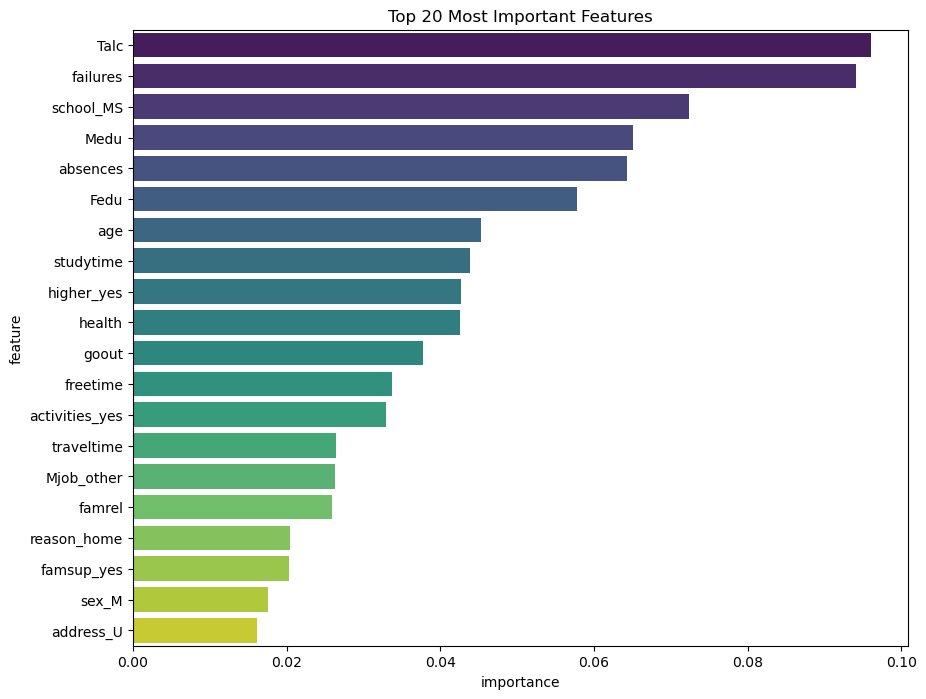

In [41]:
# 1. Initialize Model
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=0 # Changed to 0 to avoid printing 5x logs during CV
)


rf_classifier.fit(X_train_rf, y_train_rf)

# 3. Final Predictions on Hold-Out Test Set
y_pred_rf_proba = rf_classifier.predict_proba(X_test_rf)
y_pred_rf = rf_classifier.predict(X_test_rf)

# 4. Metrics
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
auc_rf = roc_auc_score(y_test_rf, y_pred_rf_proba, multi_class='ovr')

print(f"\nFinal Test Set Results:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Test Error Rate: {1 - accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")

# 5. Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train_rf.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
'''
print("\nTop 20 most important features:")
print(feature_importance.head(20))
'''
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/RF_lettergrade_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()



Let's look at the confusion matrix to see where is the model failing at.

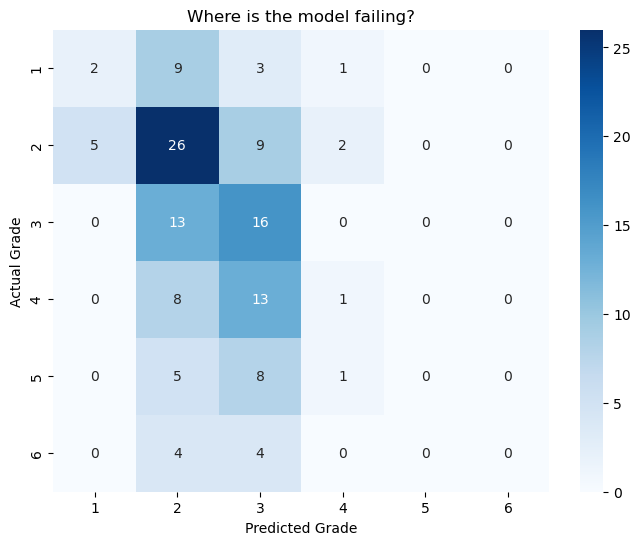

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[1,2,3,4,5,6], 
            yticklabels=[1,2,3,4,5,6])
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.title('Where is the model failing?')
plt.savefig('graphs/RF_lettergrade_confusionmatrix.png', dpi=300, bbox_inches='tight')

plt.show()

And here is the ROC graph.

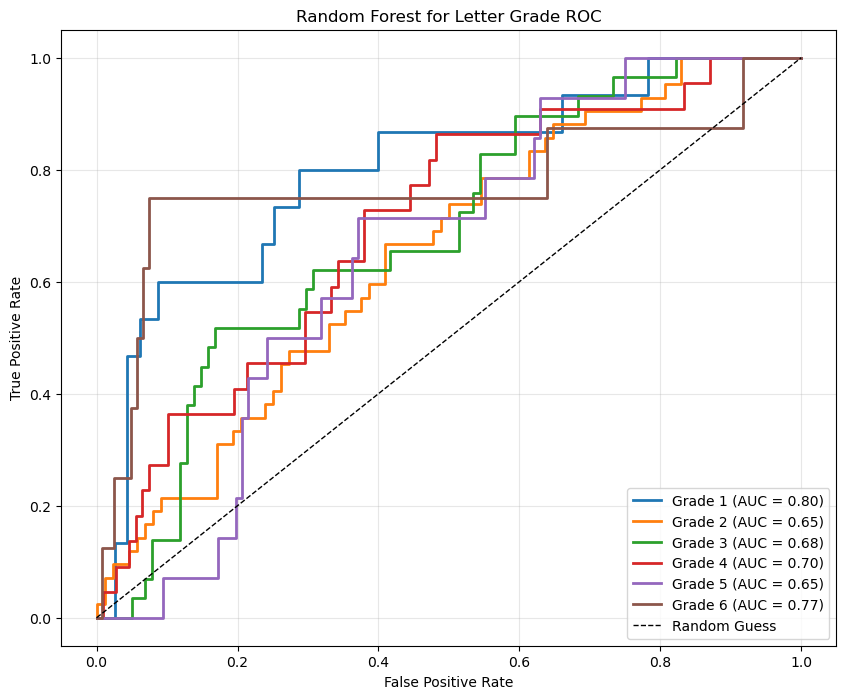

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

classes = [1, 2, 3, 4, 5, 6]
y_test_bin = label_binarize(y_test_rf, classes=classes)

# 2. Setup the Plot
plt.figure(figsize=(10, 8))

# 3. Loop through each class and plot its curve
for i, class_label in enumerate(classes):
    # Calculate FPR and TPR for just this class vs. all others
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_rf_proba[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, lw=2, label=f'Grade {class_label} (AUC = {roc_auc:.2f})')

# 4. Plot the "Random Guess" line
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess')

# 5. Final Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest for Letter Grade ROC')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('graphs/RF_lettergrade_ROC.png', dpi=300, bbox_inches='tight')

plt.show()

### 2.2 Random Forest - for performance

In [44]:
X_rf = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_rf = data['G3_cat_hl']

# One-hot encode categorical variables for modeling
X_encoded_rf = pd.get_dummies(X_rf, drop_first=True)

# Train-test split (80/20)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_encoded_rf, y_rf, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_rf.shape[0]} samples ({X_train_rf.shape[0]/len(y_rf):.1%})")
print(f"  Test set: {X_test_rf.shape[0]} samples ({X_test_rf.shape[0]/len(y_rf):.1%})")
print(f"  Features: {X_train_rf.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_rf.mean():.2f}, Std: {y_train_rf.std():.2f}")
print(f"  Test  - Mean: {y_test_rf.mean():.2f}, Std: {y_test_rf.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 0.29, Std: 0.45
  Test  - Mean: 0.34, Std: 0.48


Again, we use CV to tune the model.

In [45]:
from sklearn.model_selection import GridSearchCV

# 1. Define the "skeleton" model (only fixed settings like random_state go here)
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# 2. Define the menu of parameters to test
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [10, 20],
    'max_features': ['sqrt']
}

# 3. Initialize Grid Search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Or 'roc_auc_ovr'
    verbose=1,
    n_jobs=-1
)

# 4. RUN THE TUNING (This replaces the old .fit command)
print("Tuning model... please wait.")
grid_search.fit(X_train_rf, y_train_rf)

# 5. Extract the winner
# This 'best_rf_model' is what you use for predictions now
best_rf_model = grid_search.best_estimator_

print(f"Best params: {grid_search.best_params_}")

Tuning model... please wait.
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}



Random Forest Results:
  Accuracy: 0.6615
  Test Error Rate: 0.3385
  AUC: 0.7400


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


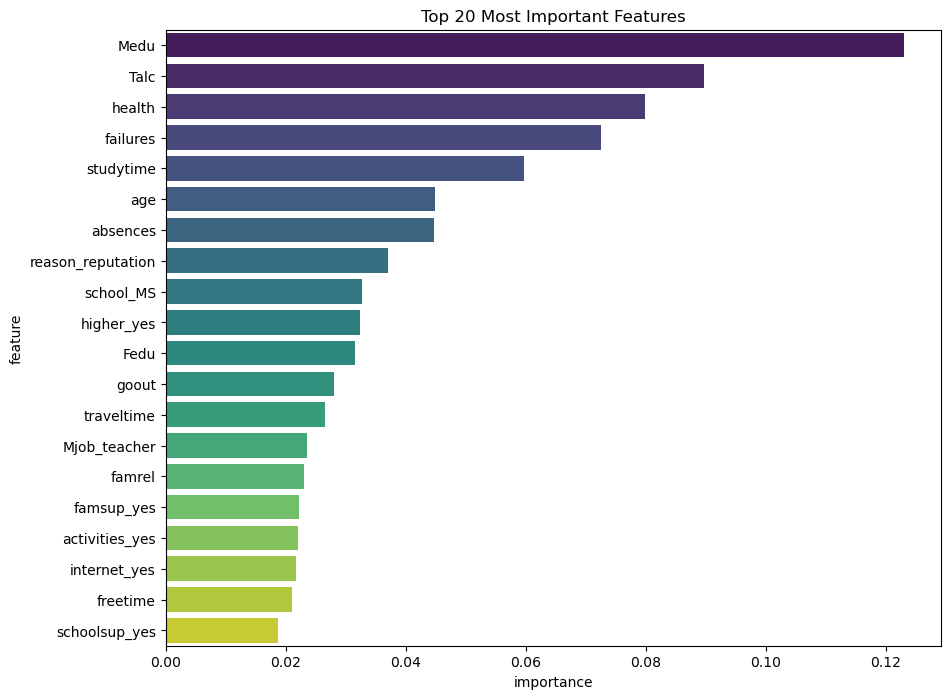

In [46]:

subset_size = 5000
X_train_rf = X_train_rf.iloc[:subset_size]
y_train_rf = y_train_rf.iloc[:subset_size]

rf_classifier = RandomForestClassifier(
    n_estimators=100,         # Number of trees
    max_depth=10,             # Maximum tree depth
    min_samples_split=20,     # Minimum samples to split
    min_samples_leaf=10,      # Minimum samples in leaf
    max_features='sqrt',      # Number of features for best split
    random_state=42,
    n_jobs=-1,                # Use all cores
    verbose=1
)

rf_classifier.fit(X_train_rf, y_train_rf)

# Predictions
y_pred_rf_proba = rf_classifier.predict_proba(X_test_rf)[:, 1]
y_pred_rf = rf_classifier.predict(X_test_rf)

# Metrics
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)
auc_rf = roc_auc_score(y_test_rf, y_pred_rf_proba)

print(f"\nRandom Forest Results:")
print(f"  Accuracy: {accuracy_rf:.4f}")
print(f"  Test Error Rate: {1 - accuracy_rf:.4f}")
print(f"  AUC: {auc_rf:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_rf.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

#print("\nTop 20 most important features:")
#print(feature_importance.head(20))
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/RF_performance_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()

We draw a confusion matrix to see where is the model failing.

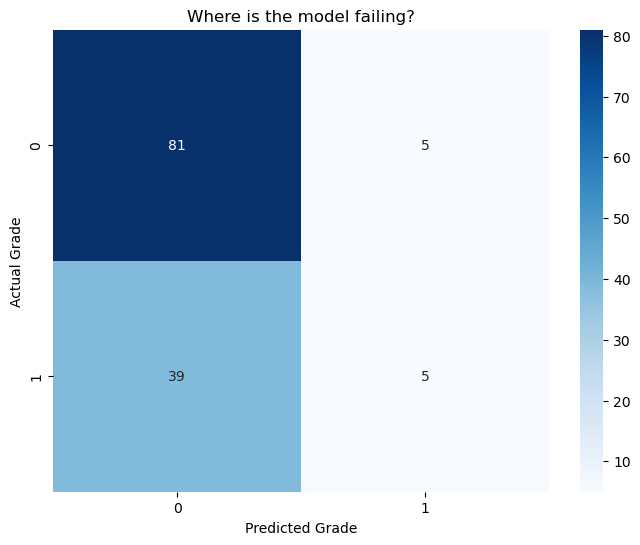

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the matrix
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[0,1], 
            yticklabels=[0,1])
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.title('Where is the model failing?')
plt.savefig('graphs/RF_performance_confusionmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

Let's look at the ROC curve.

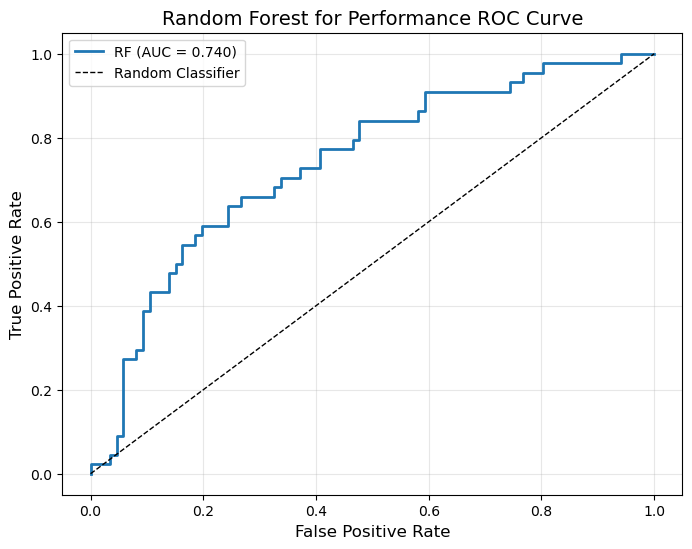

In [49]:
fpr, tpr, thresholds = roc_curve(y_test_rf, y_pred_rf_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'RF (AUC = {auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest for Performance ROC Curve', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.savefig('graphs/RF_performance_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Xgboost - for letter grade
We will first split the training and testing set

In [31]:
X_xg = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_xg = data['G3_cat']

# One-hot encode categorical variables for modeling
X_encoded_xg = pd.get_dummies(X_xg, drop_first=True)

# Train-test split (80/20)
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(
    X_encoded_xg, y_xg, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_xg.shape[0]} samples ({X_train_xg.shape[0]/len(y_xg):.1%})")
print(f"  Test set: {X_test_xg.shape[0]} samples ({X_test_xg.shape[0]/len(y_xg):.1%})")
print(f"  Features: {X_train_xg.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_xg.mean():.2f}, Std: {y_train_xg.std():.2f}")
print(f"  Test  - Mean: {y_test_xg.mean():.2f}, Std: {y_test_xg.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 2.79, Std: 1.28
  Test  - Mean: 3.02, Std: 1.40


In [32]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. CRITICAL FIX: Shift labels to start at 0
# If your classes are 1-6, this makes them 0-5.
y_train_fixed = y_train_xg - 1

# 2. Configure for Multi-Class
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # 'softprob' gives probabilities (needed for ROC later)
    eval_metric='mlogloss',      # Multi-class Log Loss
    num_class=6,                 # Explicitly tell it there are 6 classes
    use_label_encoder=False,
    random_state=42
)

# 3. Setup Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. Run Tuning
print("Tuning XGBoost (Multi-Class)... please wait.")
xgb_search.fit(X_train_xg, y_train_fixed)

print(f"Best Accuracy: {xgb_search.best_score_:.4f}")

Tuning XGBoost (Multi-Class)... please wait.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" }

Best Accuracy: 0.4085


Then, we use CV to fine tune the parameters.

Test Accuracy:  0.3231
Test Error Rate: 0.6769


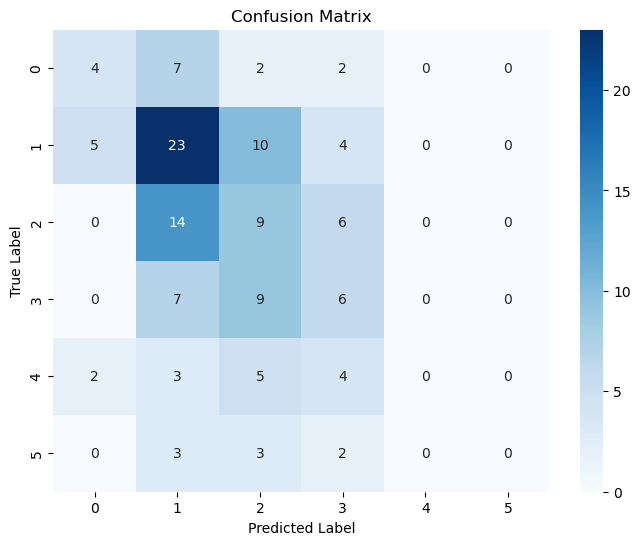

            Feature  Importance
5          failures    0.071356
12        school_MS    0.058558
35       higher_yes    0.046083
25      reason_home    0.033985
11             Talc    0.031984
36     internet_yes    0.030785
1              Medu    0.030234
30    schoolsup_yes    0.030002
28  guardian_mother    0.028534
18       Mjob_other    0.028495
3        traveltime    0.027577
2              Fedu    0.026766
14        address_U    0.026208
4         studytime    0.026115
10         absences    0.025169
29   guardian_other    0.024506
9            health    0.024287
6            famrel    0.023905
23    Fjob_services    0.023846
34      nursery_yes    0.023770


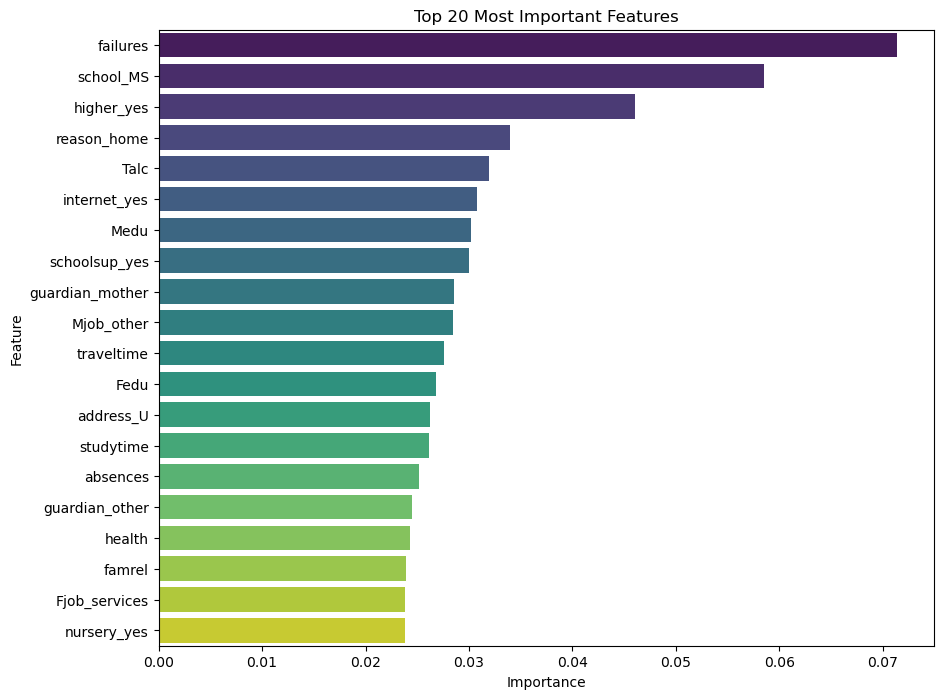

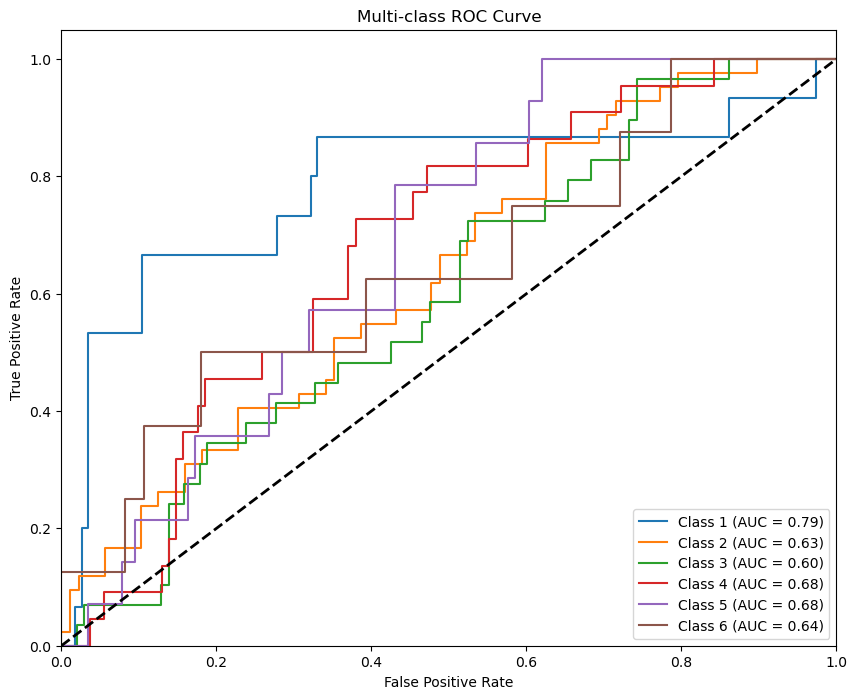

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ==========================================
# 0. PREPARE THE DATA
# ==========================================
# Get the best model from your search
best_xgb = xgb_search.best_estimator_

# IMPORTANT: Fix test labels just like you did for train (shift 1-6 to 0-5)
# If you used LabelEncoder, use: y_test_xg = le.transform(y_test_xg)
y_test_xg_fixed = y_test_xg - 1 

# Make predictions
y_pred = best_xgb.predict(X_test_xg)
y_prob = best_xgb.predict_proba(X_test_xg) # Needed for ROC

# ==========================================
# 1. TEST ERROR RATE
# ==========================================
accuracy = accuracy_score(y_test_xg_fixed, y_pred)
error_rate = 1 - accuracy
print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Error Rate: {error_rate:.4f}")

# ==========================================
# 2. CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_test_xg_fixed, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('graphs/xg_lettergrade_confusionmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. TOP 20 FEATURE IMPORTANCE
# ==========================================
# Get feature importance
importances = best_xgb.feature_importances_
feature_names = X_train_xg.columns 

# Create a DataFrame and sort
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features = feature_df.sort_values(by='Importance', ascending=False).head(20)
print(top_20_features)
# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/xg_lettergrade_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4. ROC CURVE (Multi-class)
# ==========================================
# We must binarize the output for multi-class ROC plotting
n_classes = 6
y_test_bin = label_binarize(y_test_xg_fixed, classes=[0, 1, 2, 3, 4, 5])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Add back +1 to the label name so the legend makes sense (Class 1-6)
    original_label = i + 1 
    plt.plot(fpr[i], tpr[i], label=f'Class {original_label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.savefig('graphs/xg_lettergrade_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.4 Xgboost - for performance

In [34]:
X_xg = data.drop(columns=['G3_cat','G3','G3_cat_hl'])
y_xg = data['G3_cat_hl']

# One-hot encode categorical variables for modeling
X_encoded_xg = pd.get_dummies(X_xg, drop_first=True)

# Train-test split (80/20)
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(
    X_encoded_xg, y_xg, test_size=0.2, random_state=42
)

print(f"Train-test split (80/20):")
print(f"  Training set: {X_train_xg.shape[0]} samples ({X_train_xg.shape[0]/len(y_xg):.1%})")
print(f"  Test set: {X_test_xg.shape[0]} samples ({X_test_xg.shape[0]/len(y_xg):.1%})")
print(f"  Features: {X_train_xg.shape[1]} (after one-hot encoding)")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train_xg.mean():.2f}, Std: {y_train_xg.std():.2f}")
print(f"  Test  - Mean: {y_test_xg.mean():.2f}, Std: {y_test_xg.std():.2f}")

Train-test split (80/20):
  Training set: 519 samples (80.0%)
  Test set: 130 samples (20.0%)
  Features: 38 (after one-hot encoding)

Target distribution:
  Train - Mean: 0.29, Std: 0.45
  Test  - Mean: 0.34, Std: 0.48


In [35]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# 1. Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# 2. Initialize the XGBoost Classifier
# Crucial: Set objective to 'binary:logistic' here
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# 3. Set up the Search (RandomizedSearchCV is usually faster than Grid)
# You can switch to GridSearchCV if you prefer exhaustive search
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,            # Number of combinations to try
    scoring='accuracy',   # Metric to optimize
    cv=3,                 # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1             # Use all CPU cores
)

# 4. Run the Tuning
print("Tuning XGBoost (Binary)... please wait.")
xgb_search.fit(X_train_xg, y_train_xg)

# 5. Get the Best Model
best_xgb_model = xgb_search.best_estimator_

print(f"Best Parameters found: {xgb_search.best_params_}")
print(f"Best CV Accuracy: {xgb_search.best_score_:.4f}")

Tuning XGBoost (Binary)... please wait.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/jinyifeng/anaconda3/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" }

Best Parameters found: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV Accuracy: 0.7534


Test Accuracy:  0.7538
Test Error Rate: 0.2462


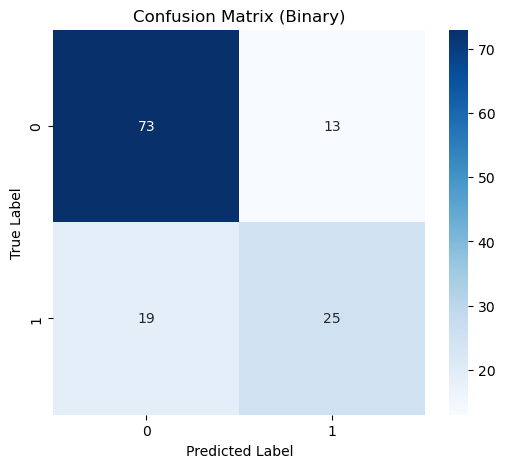

              Feature  Importance
5            failures    0.130399
30      schoolsup_yes    0.070715
35         higher_yes    0.058992
4           studytime    0.038988
1                Medu    0.033882
27  reason_reputation    0.026953
9              health    0.026219
34        nursery_yes    0.025664
11               Talc    0.025486
31         famsup_yes    0.025456
26       reason_other    0.025419
36       internet_yes    0.024660
32           paid_yes    0.024607
15        famsize_LE3    0.024601
20       Mjob_teacher    0.024188
0                 age    0.023588
3          traveltime    0.023319
14          address_U    0.023083
17        Mjob_health    0.022007
28    guardian_mother    0.021037


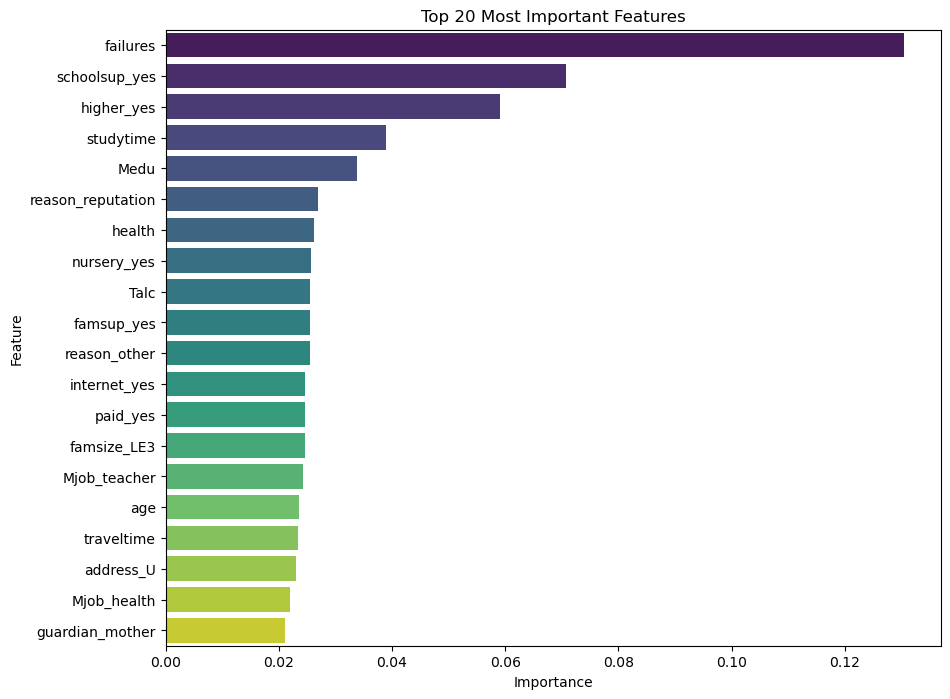

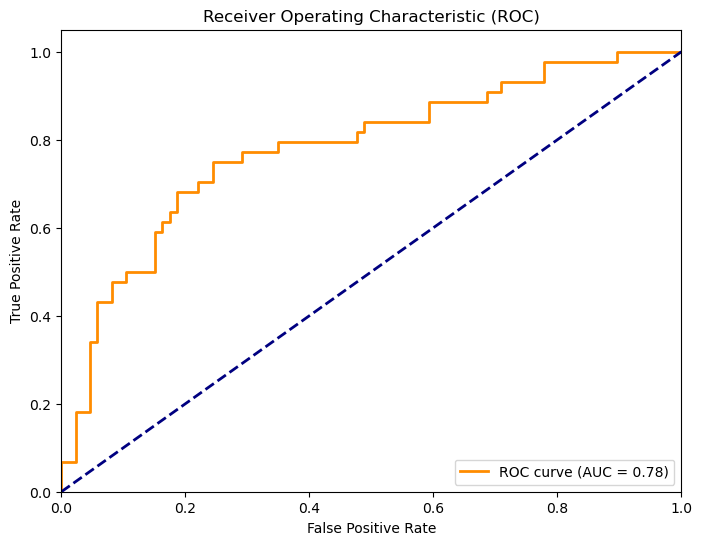

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# ==========================================
# 0. PREPARE THE DATA
# ==========================================
best_xgb = xgb_search.best_estimator_

# Get predictions
y_pred = best_xgb.predict(X_test_xg)

# Get probabilities for the POSITIVE class (Class 1) only
# .predict_proba returns [prob_class_0, prob_class_1], we want the second column
y_prob = best_xgb.predict_proba(X_test_xg)[:, 1]

# ==========================================
# 1. TEST ERROR RATE
# ==========================================
accuracy = accuracy_score(y_test_xg, y_pred)
error_rate = 1 - accuracy

print(f"Test Accuracy:  {accuracy:.4f}")
print(f"Test Error Rate: {error_rate:.4f}")

# ==========================================
# 2. CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_test_xg, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Binary)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('graphs/xg_performance_confusionmatrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. TOP 20 FEATURE IMPORTANCE
# ==========================================
importances = best_xgb.feature_importances_
feature_names = X_train_xg.columns 

feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
top_20_features = feature_df.sort_values(by='Importance', ascending=False).head(20)
print(top_20_features)
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Most Important Features')
plt.savefig('graphs/xg_performance_importantfeatures.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 4. ROC CURVE (Binary)
# ==========================================
# Calculate ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_test_xg, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('graphs/xg_performance_ROC.png', dpi=300, bbox_inches='tight')

plt.show()

# Part 3: Neural Networks & Text Mining
**Person 3 - Anushka**

Deliverables from this notebook: a word cloud, a NN vs tree accuracy comparison, and a training vs validation loss curve

The goal of this section is to explore a flexible non-linear classifier (neural network) and extract qualitative context from categorical data via a simple text-mining visualization.


### Data loading and prep

In [7]:
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from wordcloud import WordCloud

# Scikit-Learn Imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import (
    LinearRegression, 
    Lasso, LassoCV,
    Ridge, RidgeCV,
)
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier

# Configuration
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('data/student-por-cleaned.csv')

print(f"Sample size: {df.shape[0]} students, {df.shape[1]} variables")
print(f"\nVariable types:\n{df.dtypes.value_counts().to_string()}")

missing = df.isnull().sum()
print(f"\nMissing values: {'None' if missing.sum() == 0 else missing[missing > 0]}")

df.head()

Sample size: 649 students, 30 variables

Variable types:
object    17
int64     13

Missing values: None


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,health,absences,G3,Talc
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,3,4,11,2
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,3,2,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,3,6,12,5
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,5,0,14,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,5,0,13,3


## Part 1. Text Mining & Word Cloud Analysis

To summarize the qualitative context of the student population in a descriptive way, we aggregated multiple categorical variables—including parental jobs (`Mjob`, `Fjob`), reasons for school choice (`reason`), guardianship (`guardian`), and selected support/activity indicators (`schoolsup`, `activities`)—into a single tokenized text corpus. Each observation contributes tokens in the form of `column_value` (e.g., `reason_course`, `guardian_mother`), allowing us to visualize the most frequent labels via a Word Cloud. 

The full-sample cloud is dominated by `guardian_mother`, `schoolsup_no`, and `activities_no`, along with common job categories such as `fjob_other` and mid-frequency school-choice tokens like `reason_course`. This suggests that a small set of recurring coded labels accounts for much of the observed variation in the selected background columns.

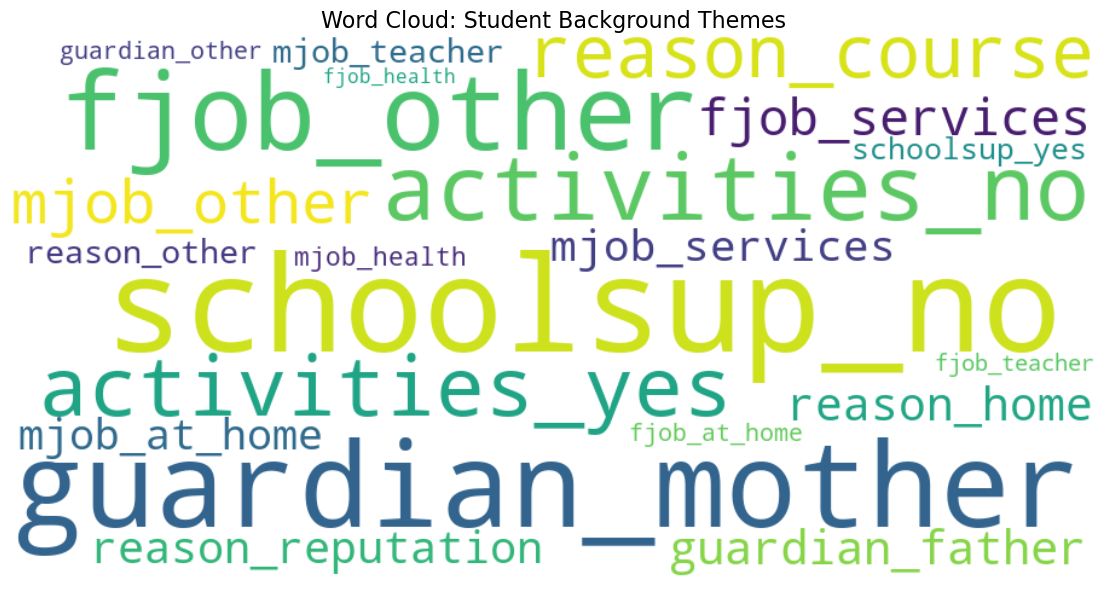

In [19]:
# verify columns exist in the dataframe to avoid errors
possible_cols = ['Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'activities']
text_cols = [c for c in possible_cols if c in df.columns]
if len(text_cols) == 0:
    raise ValueError("No valid text columns found in the dataframe.")

# We convert to string first to ensure no errors with non-text data
text_data = " ".join(
    df[text_cols]
    .fillna("")
    .astype(str)
    .apply(lambda row: " ".join([f"{col}_{row[col]}" for col in text_cols]), axis=1)
    .tolist()
).lower()

# Generate  Word Cloud
wordcloud = WordCloud(
    width=900,
    height=450,
    background_color="white",
    colormap="viridis",
    collocations=False,
    max_words=100
).generate(text_data)

# plot and save graphs
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: Student Background Themes", fontsize=16)
plt.tight_layout()
plt.savefig("graphs/word_cloud.png", bbox_inches="tight", dpi=200)
plt.show()

Next, we split the data into students with high performance (G3 >= 14) and lower performance (G3 < 10) and generate separate word clouds. The goal is not to infer causality, but to see whether the most frequent background labels differ noticeably between the two groups. Since the groups are imbalanced, these comparisons are best read as qualitative differences in relative prominence rather than precise effect estimates.

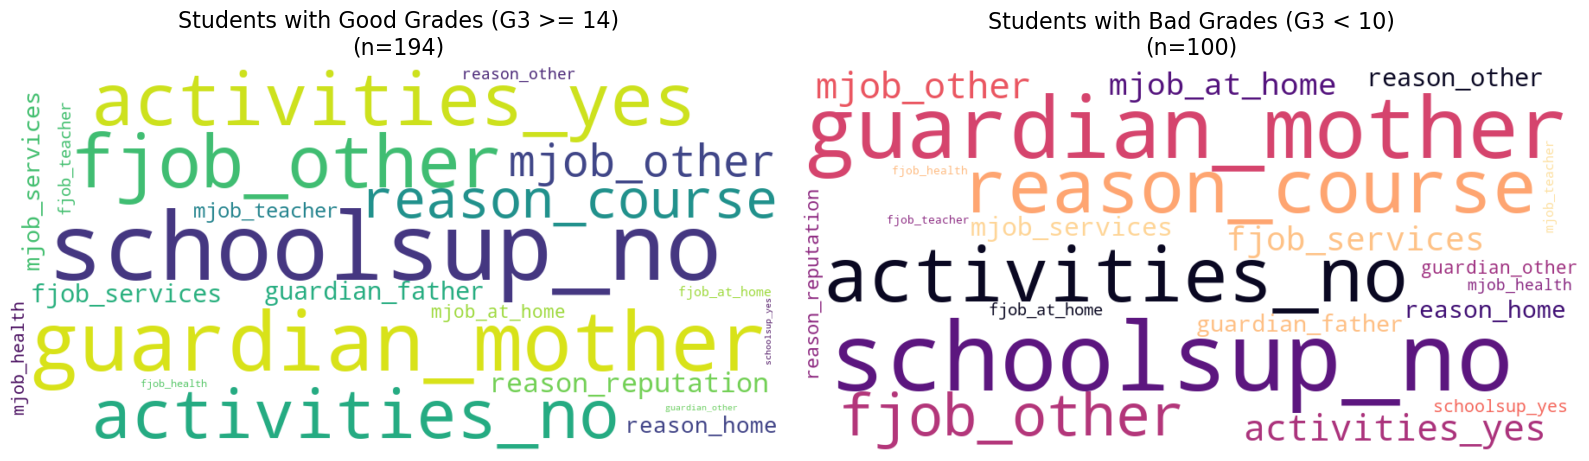

In [20]:
# We use explicit subsets as requested
good_grades_df = df[df['G3'] >= 14]
bad_grades_df  = df[df['G3'] < 10]

# Helper to build "tokenized" text g., "reason_course")
def build_text(sub_df):
    return " ".join(
        sub_df[text_cols]
        .fillna("unknown") # Safety against NaNs
        .astype(str)
        .apply(lambda row: " ".join([f"{col}_{row[col]}" for col in text_cols]), axis=1)
        .tolist()
    ).lower()

# Generate text blobs for each group
text_good = build_text(good_grades_df)
text_bad  = build_text(bad_grades_df)

# Generate Word Clouds withColormaps
wc_good = WordCloud(width=900, height=450, background_color="white",
                    collocations=False, max_words=100, colormap="viridis").generate(text_good)

wc_bad = WordCloud(width=900, height=450, background_color="white",
                   collocations=False, max_words=100, colormap="magma").generate(text_bad)

#  Plot Side-by-Side
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(wc_good, interpolation="bilinear")
plt.axis("off")
plt.title(f"Students with Good Grades (G3 >= 14)\n(n={len(good_grades_df)})", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wc_bad, interpolation="bilinear")
plt.axis("off")
plt.title(f"Students with Bad Grades (G3 < 10)\n(n={len(bad_grades_df)})", fontsize=16)

plt.tight_layout()
plt.savefig("graphs/word_cloud_good_vs_bad.png", dpi=200, bbox_inches="tight")
plt.show()

## Part 2: Neural Network vs. Decision Tree (Classification)

We formulated a binary classification task to predict student success, with the target variable set to 1 if the final grade (G3) is 14 or higher and zero otherwise. To prevent data leakage, we excluded the intermediate grades (G1 and G2) from the feature set, since they directly encode prior academic performance and would inflate predictive performance. Before modeling, numeric features were standardized, and categorical features were one-hot encoded to support neural network convergence and ensure a fair comparison across models.

We compare a Multi-Layer Perceptron (MLP) classifier - a feedforward neural network with two hidden layers (64 and 32 units), ReLU activation, and early stopping - against a baseline decision tree capped at a maximum depth of 5. The depth-limited tree provides an interpretable benchmark, while the MLP tests whether non-linear structure and feature interactions improve prediction of high performance (G3 ≥ 14) versus other outcomes.

In [22]:
# Create Binary Target
print([c for c in ["G1","G2","G3"] if c in df.columns])
print("num cols:", len(df.columns))

df["good_perf"] = (df["G3"] >= 14).astype(int)

drop_cols = [c for c in ["G3","good_perf","G1","G2"] if c in df.columns]
X = df.drop(columns=drop_cols)
y = df["good_perf"]

# define Preprocessing Pipeline
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]) 

# stratified Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# apply Transformations
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# train Neural Network 
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), 
                         activation='relu', 
                         max_iter=1000, 
                         random_state=42, 
                         early_stopping=True)
nn_model.fit(X_train_scaled, y_train)

# train Decision Tree 
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)

# evaluate and compare

nn_pred = nn_model.predict(X_test_scaled)
dt_pred = dt_model.predict(X_test_scaled)

nn_acc = accuracy_score(y_test, nn_pred)
dt_acc = accuracy_score(y_test, dt_pred)

print(f"Neural Network Accuracy: {nn_acc:.4f}")
print(f"Decision Tree Accuracy:  {dt_acc:.4f}")

['G3']
num cols: 31
Neural Network Accuracy: 0.7000
Decision Tree Accuracy:  0.7000


To assess the relative importance of alcohol consumption compared to other factors, we fitted three tree-based models using all available demographic and behavioral features. We then analyzed the feature importance to see where alcohol consumption (Talc) ranks. We compared a standard decision tree, which serves as a flexible baseline but can be sensitive to specific data splits, with a pruned version optimized via cost-complexity pruning (CCP) to identify the most robust and informative split. Finally, we employed a bagged ensemble of bootstrapped trees to reduce variance and produce a smoother, more stable decision boundary. This progression allows us to observe whether alcohol use alone provides a reliable predictor of failure, or whether its signal is too weak to stand on its own.

FULL MODEL RESULTS (all predictors)
Baseline (Always predict majority class): 0.7000
Standard Tree Accuracy:                   0.6000
Pruned Tree Accuracy:                     0.6308 (alpha=0.00511)
Bagged Trees Accuracy:                    0.6846


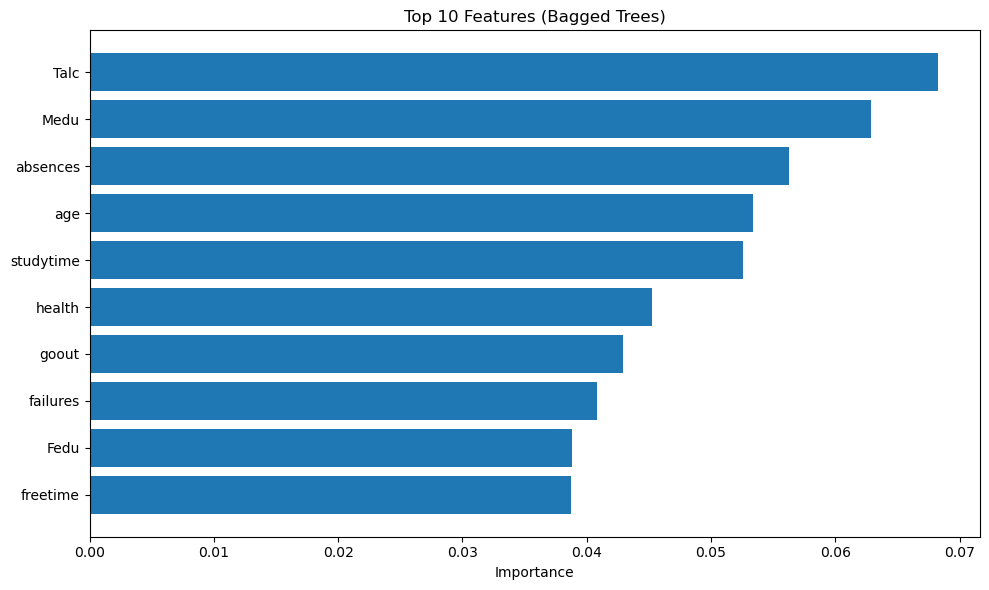

Bagged Trees Balanced Acc: 0.5989


In [ ]:
# FULL FEATURE SET (not Talc-only)
X_all = df.drop(columns=[c for c in ["G3","G1","G2","good_perf","bad_perf","passed"] if c in df.columns])
y_all = df["good_perf"].copy()

# sanity: no leakage columns left in X
assert all(c not in X_all.columns for c in ["G1","G2","G3","good_perf","bad_perf","passed"])

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe, cat_cols),
    ],
    verbose_feature_names_out=False
)

X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

# validation split for pruning selection (keep test clean)
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# standard tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
acc_dt = accuracy_score(y_test, dt.predict(X_test))

# cost-complexity pruning: choose alpha on validation split
path = dt.cost_complexity_pruning_path(X_tr2, y_tr2)
ccp_alphas = path.ccp_alphas[:-1] if len(path.ccp_alphas) > 1 else path.ccp_alphas

best_alpha, best_acc = 0, -1
for a in ccp_alphas:
    m = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    m.fit(X_tr2, y_tr2)
    acc = accuracy_score(y_val2, m.predict(X_val2))
    if acc > best_acc:
        best_acc, best_alpha = acc, a

dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
dt_pruned.fit(X_train, y_train)
acc_pruned = accuracy_score(y_test, dt_pruned.predict(X_test))

# bagging
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
bag.fit(X_train, y_train)
acc_bag = accuracy_score(y_test, bag.predict(X_test))

baseline_acc = y_test.value_counts(normalize=True).max()

print("FULL MODEL RESULTS (all predictors)")
print(f"Baseline (Always predict majority class): {baseline_acc:.4f}")
print(f"Standard Tree Accuracy:                   {acc_dt:.4f}")
print(f"Pruned Tree Accuracy:                     {acc_pruned:.4f} (alpha={best_alpha:.5f})")
print(f"Bagged Trees Accuracy:                    {acc_bag:.4f}")

# feature importance from bagged trees (average across estimators)
feature_names = preprocessor.get_feature_names_out()
bag_importances = np.mean([tree.feature_importances_ for tree in bag.estimators_], axis=0)

df_imp = (
    pd.DataFrame({"feature": feature_names, "importance": bag_importances})
      .sort_values("importance", ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 6))
plt.barh(df_imp["feature"][::-1], df_imp["importance"][::-1])
plt.title("Top 10 Features (Bagged Trees)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

from sklearn.metrics import balanced_accuracy_score
print(f"Bagged Trees Balanced Acc: {balanced_accuracy_score(y_test, bag.predict(X_test)):.4f}")



## Part 3: Training Dynamics and Loss Curve

To monitor our neural network's stability and detect potential overfitting, we tracked log loss over 60 training epochs using a held-out validation split derived from the training data. Because accuracy alone can obscure training dynamics, log loss provides a more sensitive view of whether predicted probabilities are improving in a calibrated way over time.

The gap between the curves is crucial - if the training loss continues to decrease while the validation loss either plateaus or increases, that pattern is consistent with overfitting. If both losses decrease together and remain close to each other, it suggests the model is learning patterns that transfer beyond the training data.

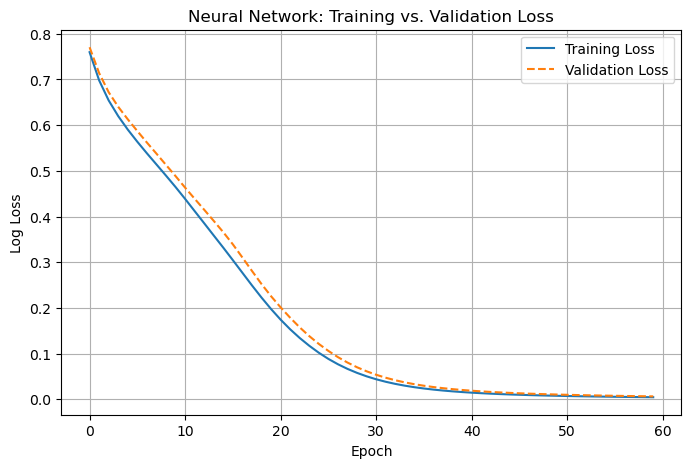

In [ ]:
# Split train into train/validation to keep test clean
X_tr_scaled, X_val_scaled, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Neural Network with Loss Tracking
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=1,
    warm_start=True,
    random_state=42
)

# Training Loop
train_losses, val_losses = [], []
epochs = 60
classes = np.unique(y_tr)

for e in range(epochs):
    mlp.partial_fit(X_tr_scaled, y_tr, classes=classes)

    p_train = mlp.predict_proba(X_tr_scaled)
    p_val   = mlp.predict_proba(X_val_scaled)

    train_losses.append(log_loss(y_tr, p_train))
    val_losses.append(log_loss(y_val, p_val))

# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Neural Network: Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("graphs/nn_loss_curve.png", bbox_inches="tight")
plt.show()


## 4. Discussion and Findings

### Qualitative insights from text mining
The word clouds are dominated by repeated categorical levels, such as `guardian_mother`, `reason_course`, and standard parental job labels (such as `Mjob_services`). Because the corpus is built from `column_value` tokens, these visuals are best interpreted as a frequency summary of coded background labels, not deeper natural-language "themes."

Stratifying by performance is more informative than looking at the overall cloud. The lower-performing group shows a higher prevalence of disengagement and low-support tokens (notably activities_no and schoolsup_no), while the higher-performing group shows comparatively more extracurricular participation (activities_yes). Taken together, this suggests the broader family and school-choice context is relatively consistent across students, while engagement-related variables may be stronger differentiators of high performance (G3 ≥ 14) than demographics alone.

### Model performance and value
On the held-out test set, both the Neural Network and the Decision Tree achieved an accuracy of 0.7000. This matches the baseline accuracy, indicating that distinguishing top-tier students using only demographic data is difficult without knowing their previous grades.
However, the training dynamics provides an important caveat - the loss curve showed validation loss flattening while training loss continued to decrease. Essentially, after a certain point, the model kept improving on the training data without meaningfully improving on the held-out data - and this is consistent with diminishing returns and a rising risk of overfitting.

### Conclusion
Overall, the neural network performed identically to the shallow decision tree in this split, with neither model managing to beat the majority-class baseline. The loss dynamics highlight that while the network began to learn, it quickly plateaued. Since the neural network did not demonstrate superior accuracy here, its 'black box' nature makes it less attractive than the transparent decision tree for this specific task. In stakeholder-facing settings where explainability matters, having interpretable baselines (like pruned decision trees or logistic regression) is still essential because they're easier to debug and explain, even at the cost of some predictive precision.

Connecting back to alcohol use, our feature importance analysis indicates that alcohol consumption is a lower-priority predictor compared to academic history (failures) and engagement (absences). It does not appear in the top 10 most important features, suggesting it is a weak standalone signal for high academic performance.

In practice, this means that screening students based solely on alcohol use would likely generate a lot of false positives. A more effective approach would be to treat alcohol as one piece of a broader profile, alongside student engagement and support indicators that stand out in the stratified word clouds. This would help us to identify more at-risk patterns, striving for a balance between accuracy and interpretability that could hold up in a real-world educational decision-making.
